Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

1. Import required libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

import shap

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from IPython.display import display

# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

1.1. Select features

In [5]:
columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']
data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

In [7]:
display(data.shape)
display(data.describe())

(4681, 13)

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,4681.000000,4681.000000,4646.000000,4678.000000,4611.000000,4215.000000,3471.000000,4388.000000
mean,62.357830,1.678701,75.471481,133.127832,106.279991,54.638434,11.375367,6.681723
std,11.038623,0.980228,16.091129,25.197232,51.464548,8.914919,4.138540,3.124519
min,26.000000,0.000000,20.000000,15.000000,3.830000,10.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,81.530000,49.000000,8.500000,5.120000
50%,63.000000,1.000000,72.000000,130.000000,97.820000,56.000000,10.700000,5.830000
75%,70.000000,2.000000,81.000000,150.000000,116.630000,61.000000,13.500000,7.100000
max,93.000000,4.000000,200.000000,260.000000,1354.000000,80.000000,43.100000,77.330000


Removing rows with NaN values

In [15]:
print("Amount of NaN values in different columns before:")
display(data.isna().sum())

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']
data_no_nan = data.dropna(subset=columns_to_check)
print("Amount of NaN values in different columns after:")
display(data_no_nan.isna().sum())

Amount of NaN values in different columns before:


Age                       0
ОССН KiLLip               0
ЧСС (b)                  35
Систолическое АД(b)       3
Креатинин                70
EF%                     466
Лейкоциты(b)           1210
Глюкоза(a)              293
начало операции        1549
Дата операции в БД        0
дата выписки           1580
дата смерти            4360
Исход заболевания         0
dtype: int64

Amount of NaN values in different columns after:


Age                       0
ОССН KiLLip               0
ЧСС (b)                   0
Систолическое АД(b)       0
Креатинин                 0
EF%                       0
Лейкоциты(b)              0
Глюкоза(a)                0
начало операции        1082
Дата операции в БД        0
дата выписки           1086
дата смерти            2920
Исход заболевания         0
dtype: int64

1.2. Explore how NaN values in 'дата выписки', 'дата смерти' are related to each other and to 'Исход заболевания'. 
Count records where both are NaN:

In [16]:

begin_end_op_and_death_dates_nan = data_no_nan.loc[
    data_no_nan['дата выписки'].isna() & 
    data_no_nan['дата смерти'].isna()]

display(begin_end_op_and_death_dates_nan.groupby('Исход заболевания').size())

Исход заболевания
без перемен                                     3
выписан с улучшением                            1
неоконченный случай с улучшением                1
переведен в другой стационар с улучшением       3
с выздоровлением                                1
с улучшением                                 1034
самоуход                                        1
dtype: int64

1.3. Examine dates and patients' conditons

In [17]:
data_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3027 entries, 18 to 12517
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Age                  3027 non-null   float64       
 1   ОССН KiLLip          3027 non-null   float64       
 2   ЧСС (b)              3027 non-null   float64       
 3   Систолическое АД(b)  3027 non-null   float64       
 4   Креатинин            3027 non-null   float64       
 5   EF%                  3027 non-null   float64       
 6   Лейкоциты(b)         3027 non-null   float64       
 7   Глюкоза(a)           3027 non-null   float64       
 8   начало операции      1945 non-null   datetime64[ns]
 9   Дата операции в БД   3027 non-null   datetime64[ns]
 10  дата выписки         1941 non-null   object        
 11  дата смерти          107 non-null    object        
 12  Исход заболевания    3027 non-null   object        
dtypes: datetime64[ns](2), float64(8

Parsing date-time columns into date-time format.

In [18]:
data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

Now checking NaN 'дата смерти' and 'Исход заболевания' for any strange rows.

In [29]:
query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"
data_no_nan_copy.query(query_expression)


,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a),начало операции,Дата операции в БД,дата выписки,дата смерти,Исход заболевания,Дата операции в БД_parsed,дата выписки_parsed,дата смерти_parsed
9761,61.0,3.0,72.0,130.0,108.0,65.0,12.9,6.37,2016-12-29 15:00:00,2016-12-29,2017-01-02 18:51:00,2017-01-02 00:00:00,самоуход,2016-12-29,2017-01-02 18:51:00,2017-01-02


This row is ambiguous. Will drop it.

In [30]:
# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"
# Drop rows that satisfy the query expression
display(data_no_nan_copy.shape)
clean_data = data_no_nan_copy.query(query_expression_2)
display(clean_data.shape)

(3027, 16)

(3026, 16)

Keeping only death cases within 55 days from the operation date.

Note: If there is no information about "Дата смерти", but "Исход заболевания" is "умер", we will consider the date from "Дата выписки" as the day of death.

In [31]:
mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask

In [34]:
print(f"Rows to drop: {clean_data[mask].shape[0]}")
ready_data = clean_data[rows_to_keep]
print(f"Rows left in the dataset: {ready_data.shape[0]}")

Rows to drop: 2
Rows left in the dataset: 3024


In [35]:
ready_data.describe()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


2. Split the dataset into features and target.

In [38]:
X = ready_data[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = ready_data['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

In [37]:
display(X.describe())

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


2.1. Split features and target into train and test sets

In [39]:
# Randomly shuffle the data
shuffled_indices = np.random.permutation(len(X))
X_shuffled = X.iloc[shuffled_indices]
y_shuffled = y.iloc[shuffled_indices]

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=25)


3. Data preprocessing pipeline

To evaluate the influence of different scaling methods (Standard and MinMax) we create two sets respectively.

In [40]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

def perform_scaling(my_scaler, df)->pd.DataFrame:
    return pd.DataFrame(my_scaler.fit_transform(df), columns=df.columns, index=df.index)

std_set = {'X_train': perform_scaling(std_scaler, X_train),
            'X_test':  perform_scaling(std_scaler, X_test)}

mm_set = {'X_train': perform_scaling(min_max_scaler, X_train),
            'X_test':  perform_scaling(min_max_scaler, X_test)}

original_set = {'X_train': X_train,
                'X_test': X_test}

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,2.419000e+03,2419.000000,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03,2.419000e+03
mean,1.028069e-17,0.000000,-1.968018e-16,5.287213e-16,-3.231075e-17,7.637086e-17,1.013383e-16,-1.802793e-16
std,1.000207e+00,1.000207,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00,1.000207e+00
min,-3.339121e+00,-1.756311,-3.052005e+00,-4.921363e+00,-1.901987e+00,-3.886113e+00,-2.786897e+00,-2.078561e+00
25%,-6.745169e-01,-0.697886,-6.525547e-01,-5.701109e-01,-4.507608e-01,-5.297479e-01,-7.068326e-01,-4.637435e-01
50%,6.054623e-02,-0.697886,-1.726646e-01,-1.557059e-01,-1.449951e-01,1.415251e-01,-1.620537e-01,-2.470637e-01
75%,7.037265e-01,0.360538,3.757812e-01,6.731040e-01,1.988289e-01,7.009192e-01,5.313012e-01,1.230317e-01
max,2.725150e+00,2.477387,5.860239e+00,3.988344e+00,2.316393e+01,2.826617e+00,6.796258e+00,2.238253e+01


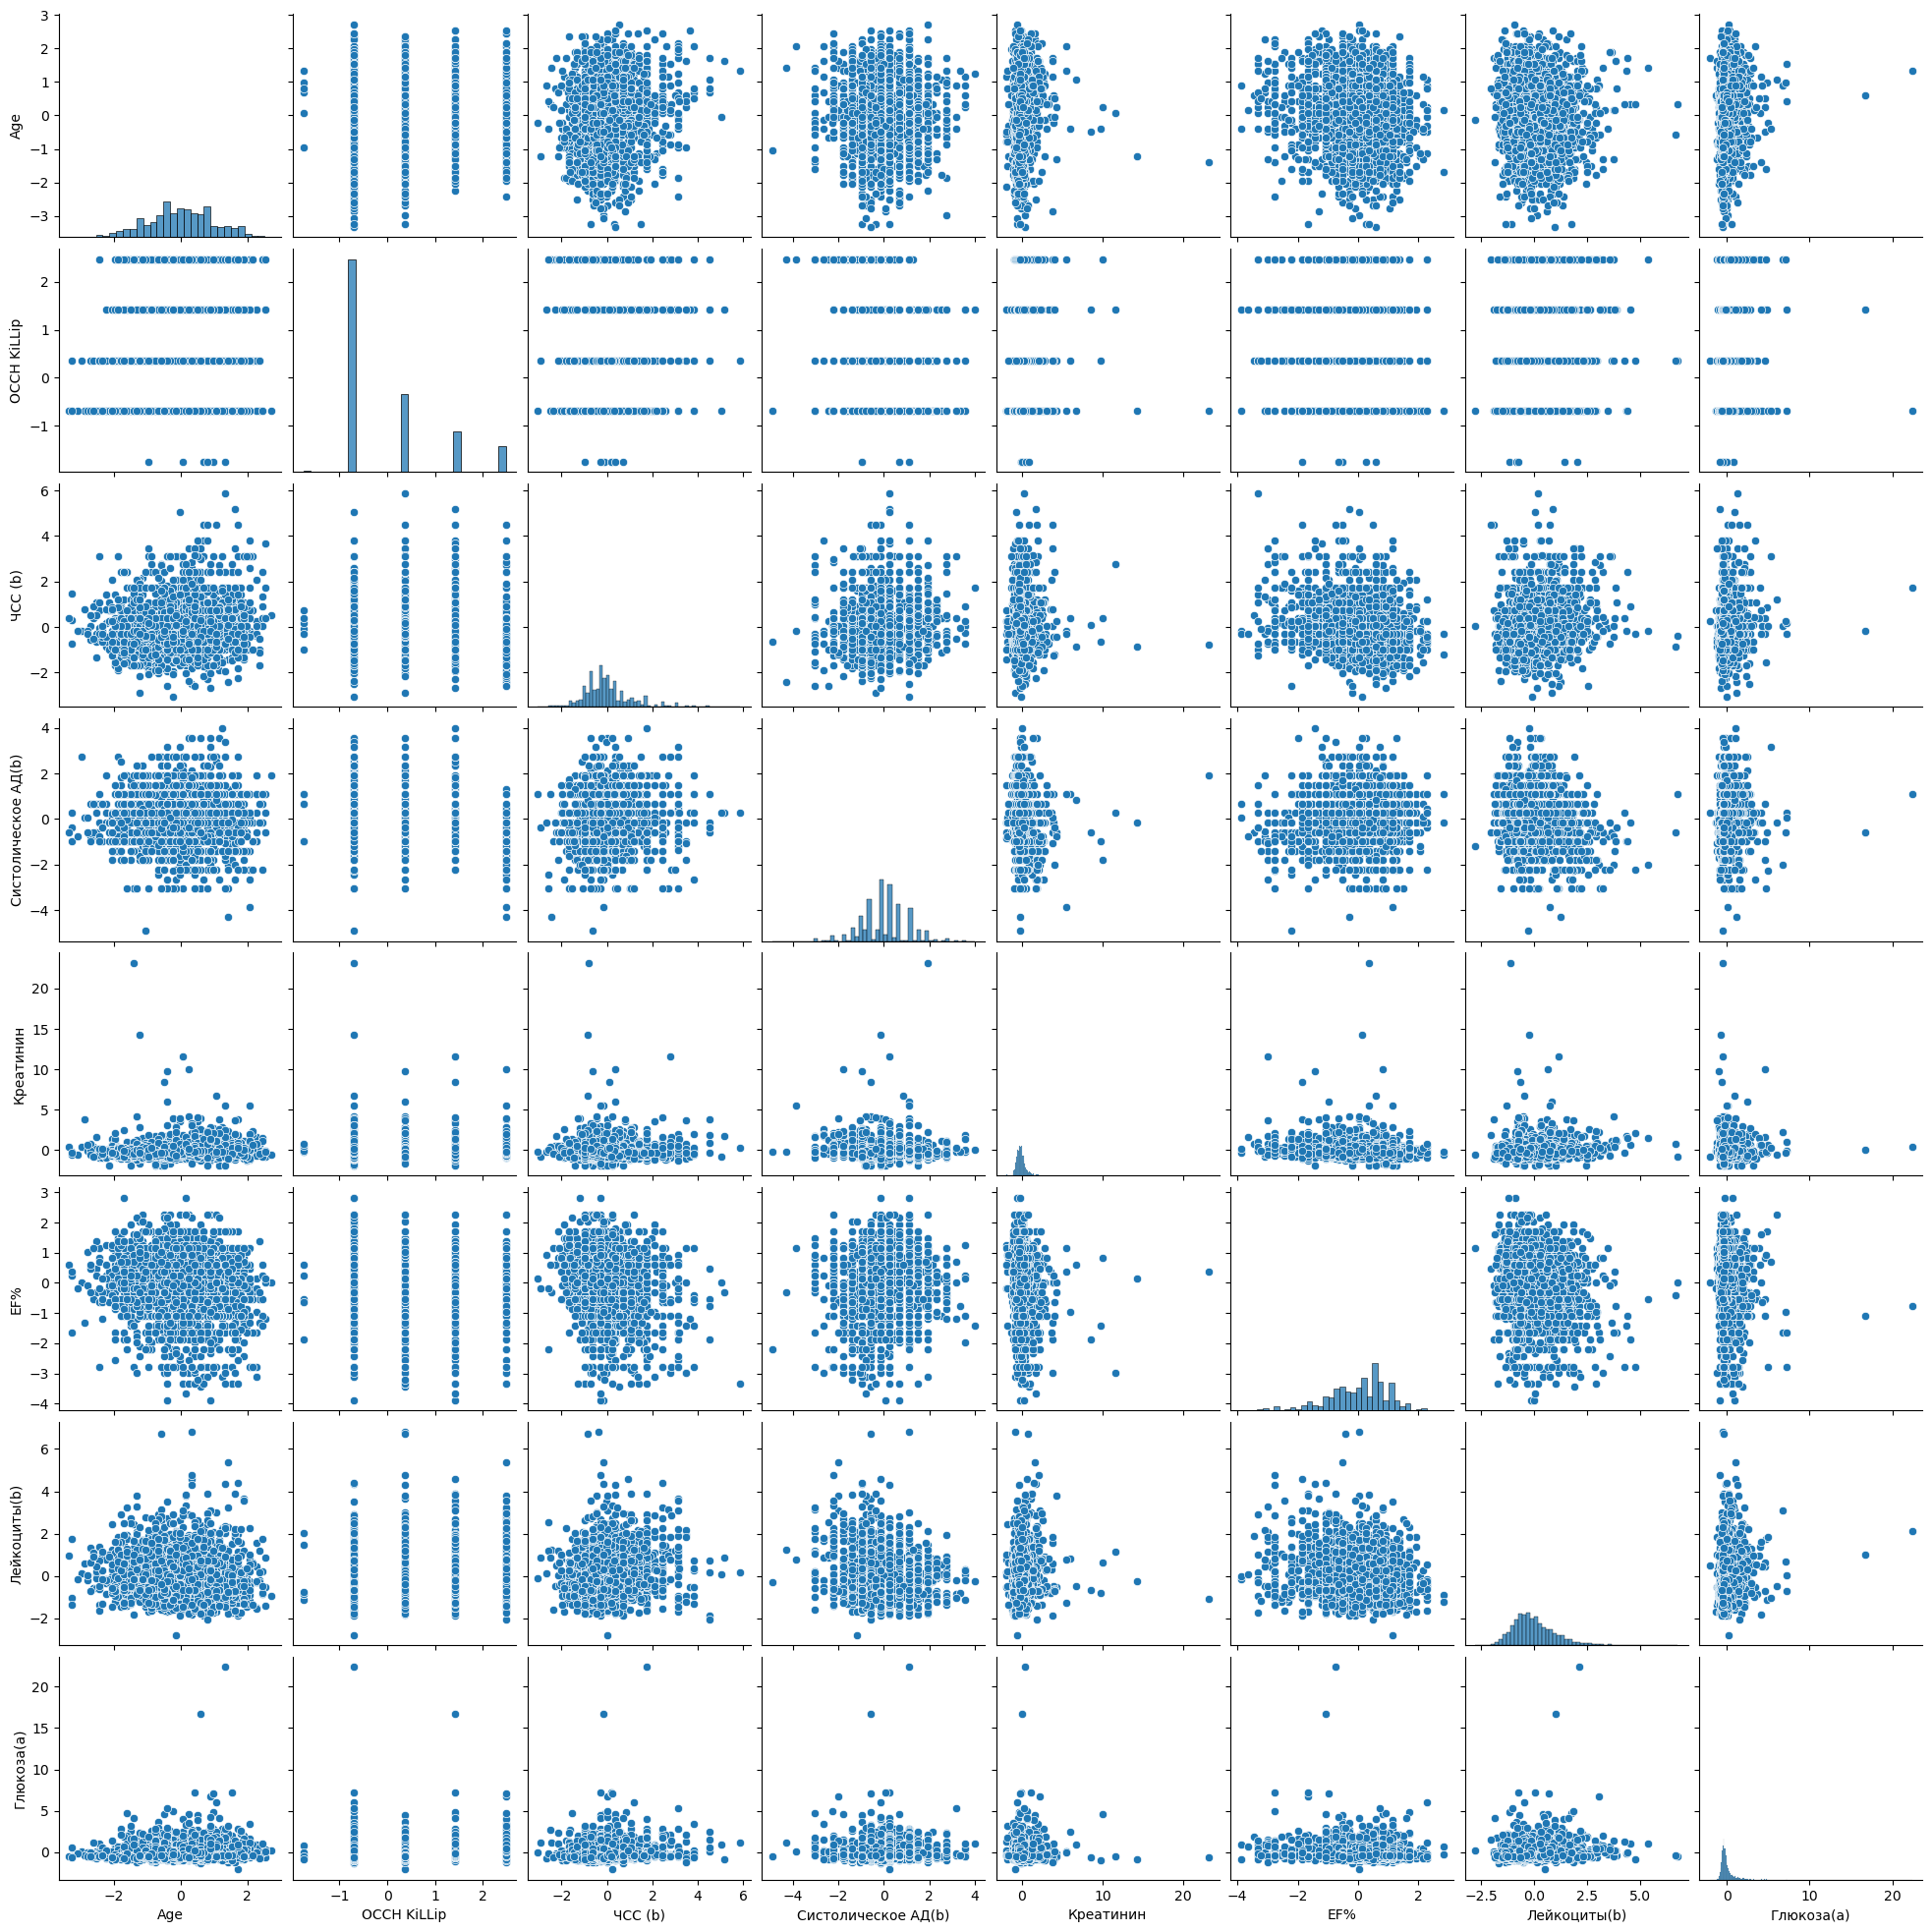

In [41]:
display(std_set['X_train'].describe())
sns.pairplot(std_set['X_train'])
plt.show()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000,2419.000000
mean,0.550622,0.414841,0.342451,0.552360,0.075879,0.578917,0.290812,0.084974
std,0.164934,0.236249,0.112228,0.112260,0.039903,0.149001,0.104371,0.040890
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.439394,0.250000,0.269231,0.488372,0.057896,0.500000,0.217054,0.066016
50%,0.560606,0.250000,0.323077,0.534884,0.070095,0.600000,0.273902,0.074874
75%,0.666667,0.500000,0.384615,0.627907,0.083812,0.683333,0.346253,0.090004
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


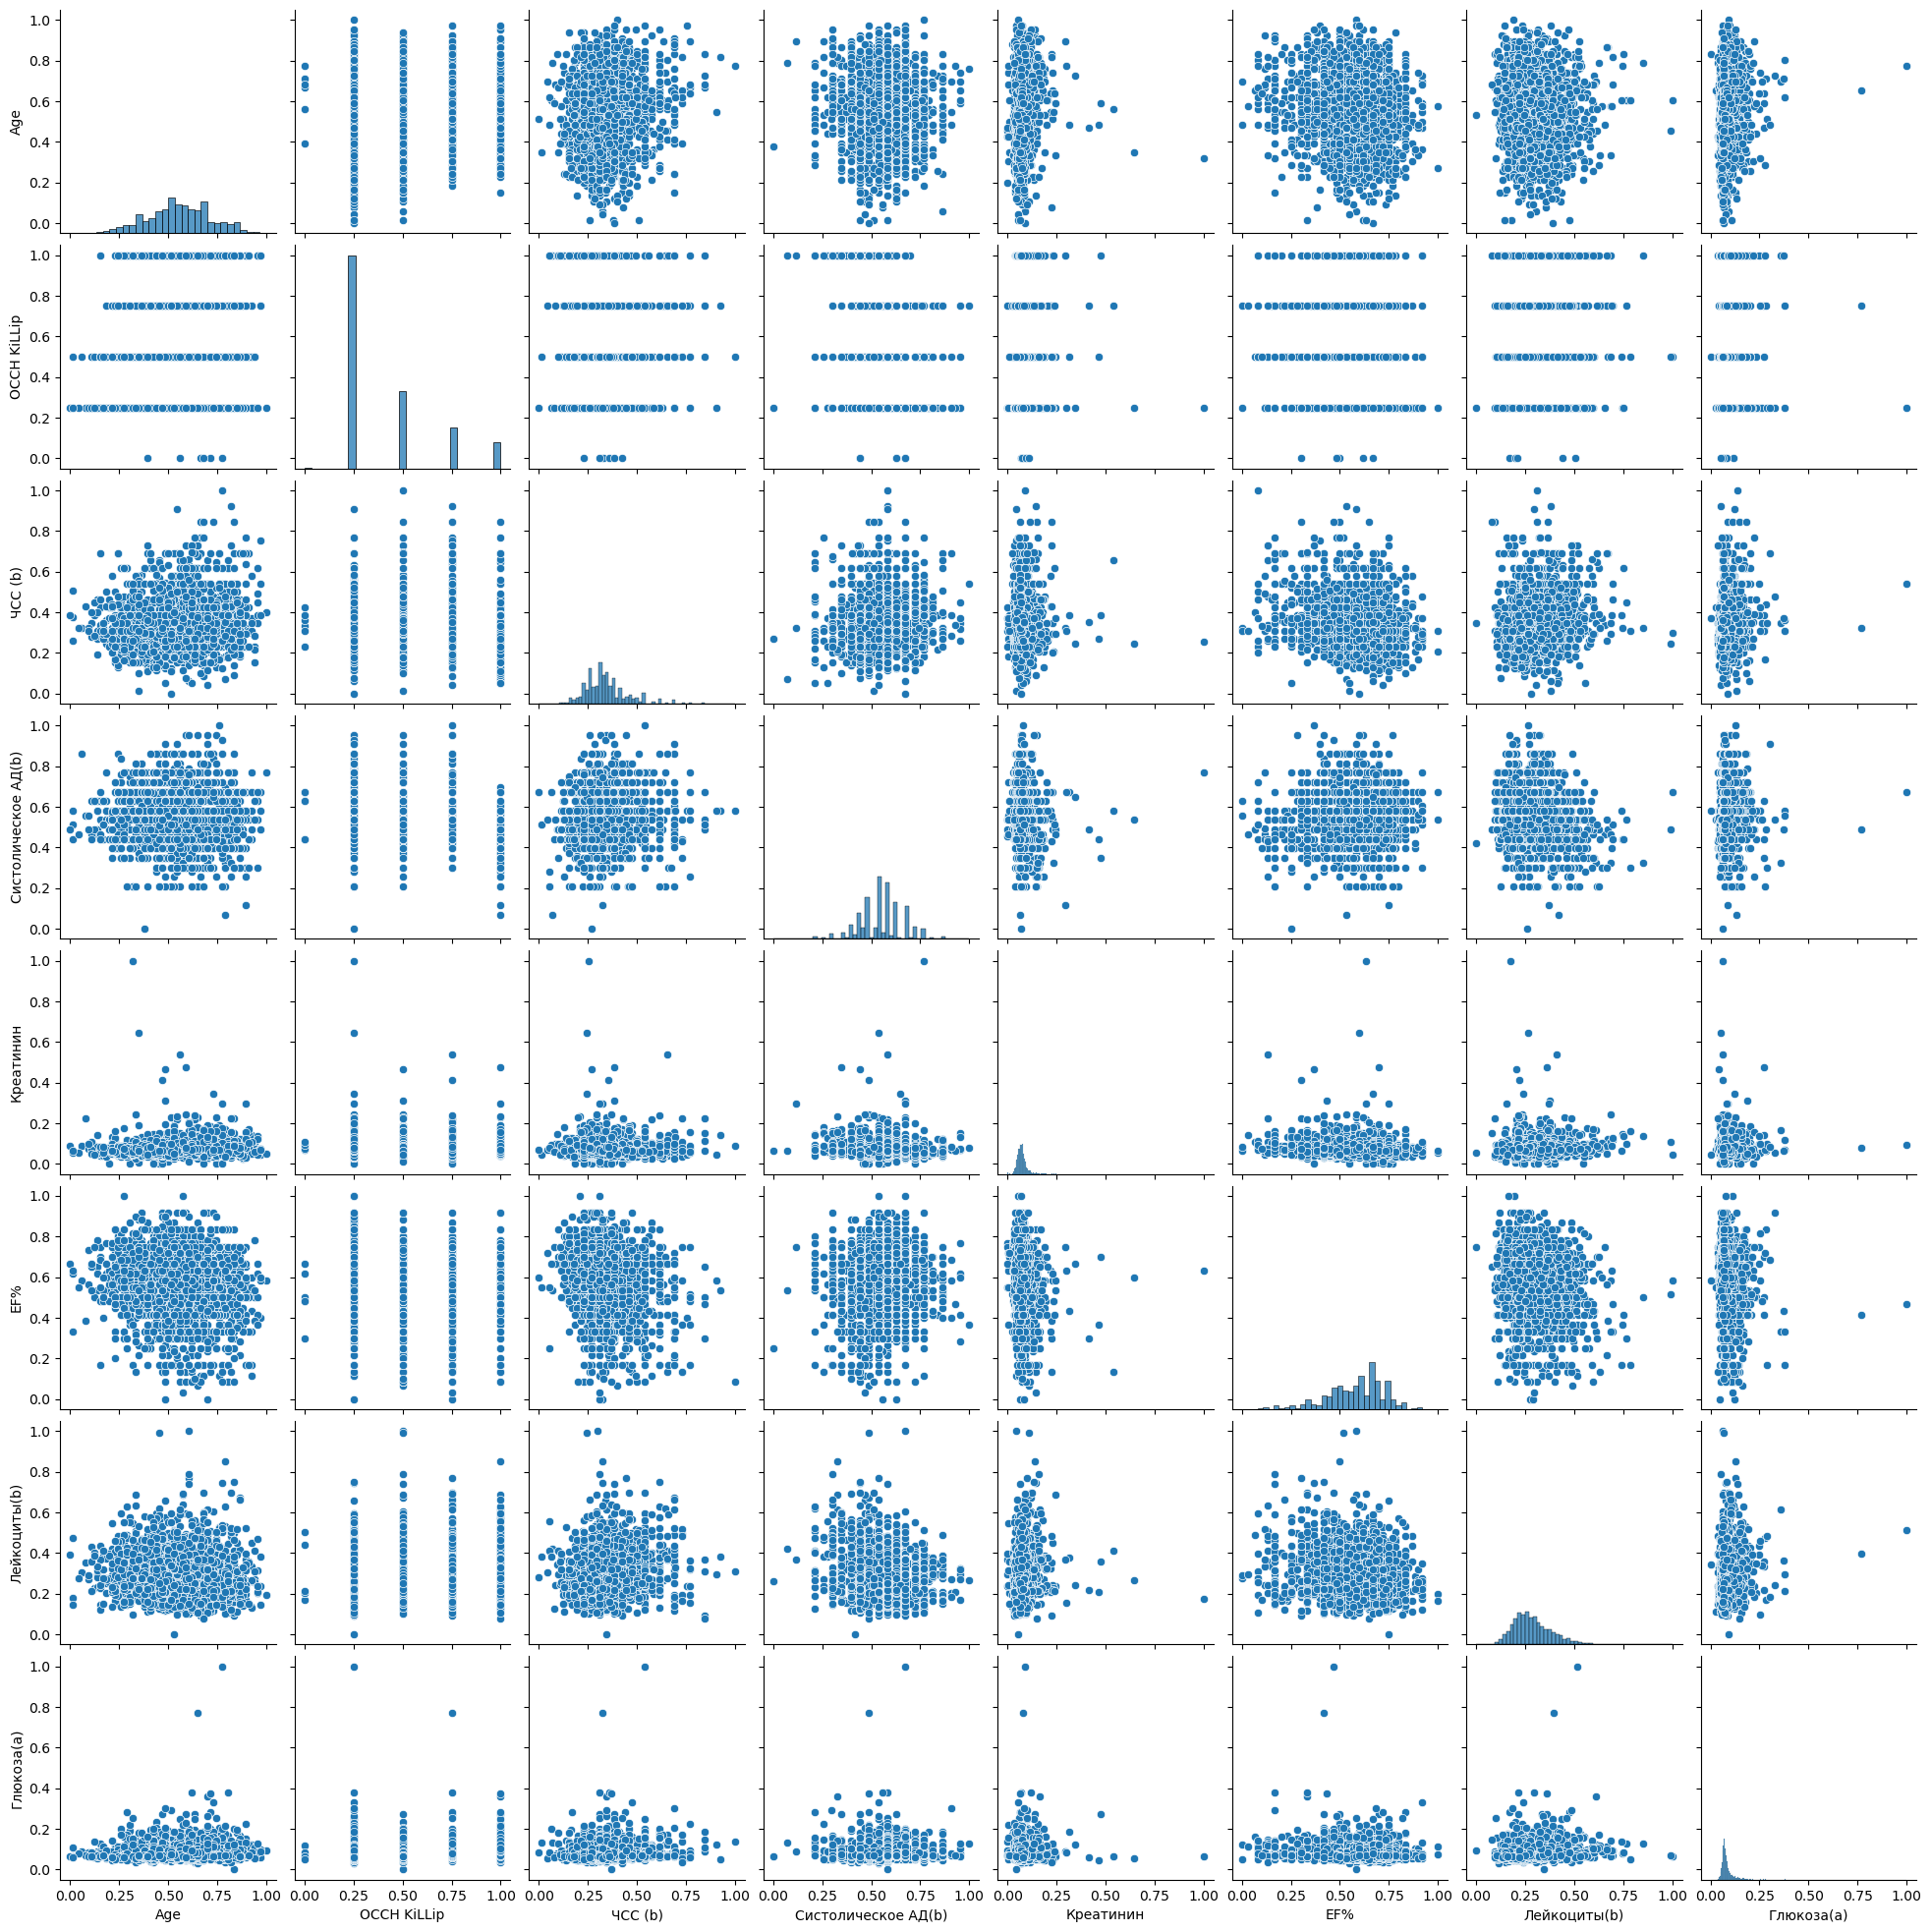

In [42]:
display(mm_set['X_train'].describe())
sns.pairplot(mm_set['X_train'])
plt.show()

There are different algorithms for calculating SHAP values:

1. Kernel SHAP: This method is model-agnostic and uses a weighted linear regression to estimate SHAP values. It is computationally expensive, especially for large datasets, but provides accurate explanations for any model. Use this method when you have a model that is not tree-based or linear, and you need a model-agnostic explanation. It is computationally expensive, so it's not suitable for large datasets or real-time explanations.

2. Tree SHAP: This method is designed specifically for tree-based models, such as decision trees, random forests, and gradient boosting machines. Tree SHAP is computationally efficient and provides exact SHAP values for tree-based models.

3. Linear SHAP: This method is specific to linear models. It calculates SHAP values by multiplying the feature values by the coefficients of the linear model.

4. Deep SHAP (DeepLIFT SHAP): This method is tailored for deep learning models, such as neural networks. Deep SHAP combines the DeepLIFT algorithm with SHAP value estimation, providing explanations for complex deep learning models.

5. Partition SHAP: This method is model-agnostic and uses a combination of random partitioning and model evaluations to compute SHAP values. It is more scalable than Kernel SHAP, but may be less accurate in some cases.

6. Monte Carlo SHAP: This method approximates SHAP values using random sampling, making it more computationally efficient than Kernel SHAP, but potentially less accurate. It can be used with any model.

In [43]:
def compute_mean_abs_shap_values(model, data, shap_algorithm):
    if shap_algorithm == 'kernel':
        explainer = shap.KernelExplainer(model.predict, data['X_train'])
        shap_values = explainer.shap_values(data['X_test'])
        display(shap_values)
        return np.abs(shap_values).mean(axis=0)
    elif shap_algorithm == 'tree':
        explainer = shap.TreeExplainer(model, data['X_train'])
        shap_values = explainer(data['X_test'], check_additivity=False)
        return np.abs(shap_values.values).mean(axis=0) 
    elif shap_algorithm == 'linear':
        explainer = shap.LinearExplainer(model, data['X_train'])
    elif shap_algorithm == 'deep':
        explainer = shap.DeepExplainer(model, data['X_train'].values)
        shap_values = explainer.shap_values(data['X_test'])
        return np.abs(shap_values.values).mean(axis=0)
    elif shap_algorithm == 'partition':
        explainer = shap.PartitionExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'monte_carlo':
        explainer = shap.MonteCarloExplainer(model.predict, data['X_train'])
    elif shap_algorithm == 'gradient':
        explainer = shap.GradientExplainer(model, data['X_train'])
    else:
        raise ValueError("Invalid SHAP algorithm name. Valid options are: 'kernel', 'tree', 'linear', 'deep', 'partition', 'monte_carlo' or 'gradient'.")

    shap_values = explainer(data['X_test']) 
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

    return mean_abs_shap_values

4. Regression models

In [44]:
combined_weights_regression_df = None #this df contains weights of features calculated for regression models

In [45]:
def create_weights_df(feature_weights=None, model_info="", index_columns=X_train.columns, shap_values=None):
    # Create a MultiIndex for columns to include model_info and the corresponding values ('Weight', 'SHAP')
    columns = pd.MultiIndex.from_product([[model_info], ['Weight', 'SHAP']])

    # Create a DataFrame with feature names as index and feature_weights as 'Weight' values
    weights_df = pd.DataFrame(index=index_columns, columns=columns)
   
    if feature_weights is not None:
        weights_df[(model_info, 'Weight')] = feature_weights
    else:
        weights_df[(model_info, 'Weight')] = np.nan
    

    if shap_values is not None:
        weights_df[(model_info, 'SHAP')] = shap_values
    else:
        weights_df[(model_info, 'SHAP')] = np.nan

    return weights_df

Calculate weights for univariate linear regression.

In [46]:
def perform_univariate_linear_regression(scaled_data, model_info='')->pd.DataFrame:
    feature_weights = []
    for feature_name in  scaled_data['X_train'].columns:
        lr = LinearRegression()
        lr.fit( scaled_data['X_train'][[feature_name]], y_train)

        # Feature weight estimation
        feature_weights.append(lr.coef_[0])

    weights_df =create_weights_df(feature_weights, 
                                model_info=f'Univariate linear regression with {model_info}')
    return weights_df

Calculate weights and SHAP values for multivariate linear regression.

In [47]:
def perform_multivariate_linear_regression(scaled_data, model_info='')->pd.DataFrame:
    feature_weights = []

    lr_multi = LinearRegression()
    lr_multi.fit( scaled_data['X_train'], y_train)

    # Feature weight estimation
    feature_weights = lr_multi.coef_

    # Shapley values for Multivariate Linear Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(lr_multi, 
                                                        scaled_data, 
                                                        shap_algorithm='linear')
    
    weights_df = create_weights_df(feature_weights,                                   
                                    model_info=f'Multivariate linear regression with {model_info}',
                                    shap_values=mean_abs_shap_values)
    return weights_df

Calculate weights and shap values for logistic regression model

In [48]:
from sklearn.linear_model import LogisticRegression

def perform_logistic_regression(scaled_data, model_info=''):
    feature_weights = []

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit( scaled_data['X_train'], y_train)

    # Feature weight estimation
    feature_weights = log_reg.coef_[0]

    # Shapley values for Logistic Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(log_reg, 
                                                        scaled_data, 
                                                        shap_algorithm='linear')

    weights_df = create_weights_df(feature_weights,
                                    model_info=f'Logistic regression with {model_info}',
                                    shap_values=mean_abs_shap_values)
    return weights_df

Put all weight and shap values together

In [49]:
univariate_weights_orgnl_df = perform_univariate_linear_regression(original_set, model_info='NoScaler')
univariate_weights_std_df = perform_univariate_linear_regression(std_set, model_info='StandardScaler')
univariate_weights_mm_df = perform_univariate_linear_regression(mm_set, model_info='MinMaxScaler')

multivariate_weights_orgnl_shap_df = perform_multivariate_linear_regression(original_set, model_info='NoScaler')
multivariate_weights_std_shap_df = perform_multivariate_linear_regression(std_set, model_info='StandardScaler')
multivariate_weights_mm_shap_df = perform_multivariate_linear_regression(mm_set, model_info='MinMaxScaler')

logistic_regression_std_df = perform_logistic_regression(std_set, model_info='StandardScaler')

combined_weights_regression_df = pd.concat([univariate_weights_orgnl_df,
                                 univariate_weights_std_df,
                                 univariate_weights_mm_df,
                                 multivariate_weights_orgnl_shap_df,
                                 multivariate_weights_std_shap_df,
                                 multivariate_weights_mm_shap_df,
                                 logistic_regression_std_df
                                 ], axis=1)

In [50]:
display(combined_weights_regression_df)
display(combined_weights_regression_df.describe())

Univariate linear regression with NoScaler       \
                                                        Weight SHAP   
Age                                                   0.001865  NaN   
ОССН KiLLip                                           0.036860  NaN   
ЧСС (b)                                               0.002193  NaN   
Систолическое АД(b)                                  -0.000993  NaN   
Креатинин                                             0.000740  NaN   
EF%                                                  -0.004613  NaN   
Лейкоциты(b)                                          0.006543  NaN   
Глюкоза(a)                                            0.011534  NaN   

                    Univariate linear regression with StandardScaler       \
                                                              Weight SHAP   
Age                                                         0.020298  NaN   
ОССН KiLLip                                                 0.034825  NaN   
ЧСС (b)                                                     0.031982  NaN   
Систолическое АД(b)                                        -0.023955  NaN   
Креатинин                                                   0.039847  NaN   
EF%                                                        -0.041234  NaN   
Лейкоциты(b)                                                0.026421  NaN   
Глюкоза(a)                                                  0.036462  NaN   

                    Univariate linear regression with MinMaxScaler       \
                                                            Weight SHAP   
Age                                                       0.123090  NaN   
ОССН KiLLip                                               0.147439  NaN   
ЧСС (b)                                                   0.285032  NaN   
Систолическое АД(b)                                      -0.213435  NaN   
Креатинин                                                 0.998796  NaN   
EF%                                                      -0.276790  NaN   
Лейкоциты(b)                                              0.253198  NaN   
Глюкоза(a)                                                0.891896  NaN   

                    Multivariate linear regression with NoScaler            \
                                                          Weight      SHAP   
Age                                                     0.000761  0.006593   
ОССН KiLLip                                             0.015079  0.011905   
ЧСС (b)                                                 0.001229  0.013828   
Систолическое АД(b)                                    -0.000590  0.010488   
Креатинин                                               0.000552  0.013274   
EF%                                                    -0.002796  0.020148   
Лейкоциты(b)                                            0.002189  0.006625   
Глюкоза(a)                                              0.008322  0.014578   

                    Multivariate linear regression with StandardScaler  \
                                                                Weight   
Age                                                           0.008284   
ОССН KiLLip                                                   0.014247   
ЧСС (b)                                                       0.017929   
Систолическое АД(b)                                          -0.014242   
Креатинин                                                     0.029707   
EF%                                                          -0.024989   
Лейкоциты(b)                                                  0.008840   
Глюкоза(a)                                                    0.026308   

                               \
                         SHAP   
Age                  0.006576   
ОССН KiLLip          0.011527   
ЧСС (b)              0.012911   
Систолическое АД(b)  0.010666   
Креатинин            0.019453   
EF%                  0.020080   
Л

Univariate linear regression with NoScaler       \
                                          Weight SHAP   
count                                   8.000000  0.0   
mean                                    0.006766  NaN   
std                                     0.013089  NaN   
min                                    -0.004613  NaN   
25%                                     0.000307  NaN   
50%                                     0.002029  NaN   
75%                                     0.007790  NaN   
max                                     0.036860  NaN   

      Univariate linear regression with StandardScaler       \
                                                Weight SHAP   
count                                         8.000000  0.0   
mean                                          0.015581  NaN   
std                                           0.030694  NaN   
min                                          -0.041234  NaN   
25%                                           0.009234  NaN   
50%                                           0.029202  NaN   
75%                                           0.035234  NaN   
max                                           0.039847  NaN   

      Univariate linear regression with MinMaxScaler       \
                                              Weight SHAP   
count                                       8.000000  0.0   
mean                                        0.276153  NaN   
std                                         0.460961  NaN   
min                                        -0.276790  NaN   
25%                                         0.038959  NaN   
50%                                         0.200318  NaN   
75%                                         0.436748  NaN   
max                                         0.998796  NaN   

      Multivariate linear regression with NoScaler            \
                                            Weight      SHAP   
count                                     8.000000  8.000000   
mean                                      0.003093  0.012180   
std                                       0.005799  0.004443   
min                                      -0.002796  0.006593   
25%                                       0.000266  0.009522   
50%                                       0.000995  0.012589   
75%                                       0.003722  0.014016   
max                                       0.015079  0.020148   

      Multivariate linear regression with StandardScaler            \
                                                  Weight      SHAP   
count                                           8.000000  8.000000   
mean                                            0.008260  0.013191   
std                                             0.019001  0.005298   
min                                            -0.024989  0.006576   
25%                                             0.002653  0.009731   
50%                                             0.011543  0.012219   
75%                                             0.020024  0.017905   
max                                             0.029707  0.020080   

      Multivariate linear regression with MinMaxScaler            \
                                                Weight      SHAP   
count                                         8.000000  8.000000   
mean                                          0.181071  0.036062   
std                                           0.335817  0.049103   
min                                          -0.167747  0.007704   
25%                                           0.005957  0.011420   
50%                                           0.072513  0.014783   
75%                                           0.280722  0.030625   
max                                           0.744633  0.151558   

      Logistic regression with StandardScaler            
                                       Weight      SHAP  
count                                8.000000  8.00000

Let's plot these values.

In [51]:
def flatten_df(df)->pd.DataFrame:
    # We need to flatten the table
    long_format_df = df.reset_index().melt(id_vars='index', var_name=['Model Info', 'Value Type'], value_name='Value')
    long_format_df = long_format_df.rename(columns={'index': 'Feature'})

    # Filter out rows corresponding to the SHAP values for univariate regression, because they are NaN
    shap_mask = long_format_df['Value Type'] == 'SHAP'
    univariate_mask = long_format_df['Model Info'].str.startswith('Univariate')
    flat_df = long_format_df.loc[~(shap_mask & univariate_mask)]
    return flat_df

In [52]:
def plot_values(flat_df, value_type='Weight'):
    weights_df = flat_df.loc[flat_df['Value Type'] == value_type]
    plt.figure(figsize=(15, 20))
    ax = sns.barplot(data=weights_df, x='Model Info', y='Value', hue='Feature', palette='deep')

    for p in ax.patches:
        y_offset = 3 if p.get_height() >= 0 else -15
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=6, color='black', 
                    xytext=(0, y_offset), textcoords='offset points')

    # plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', borderaxespad=0.)
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.title(f'Feature {value_type} for Different Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

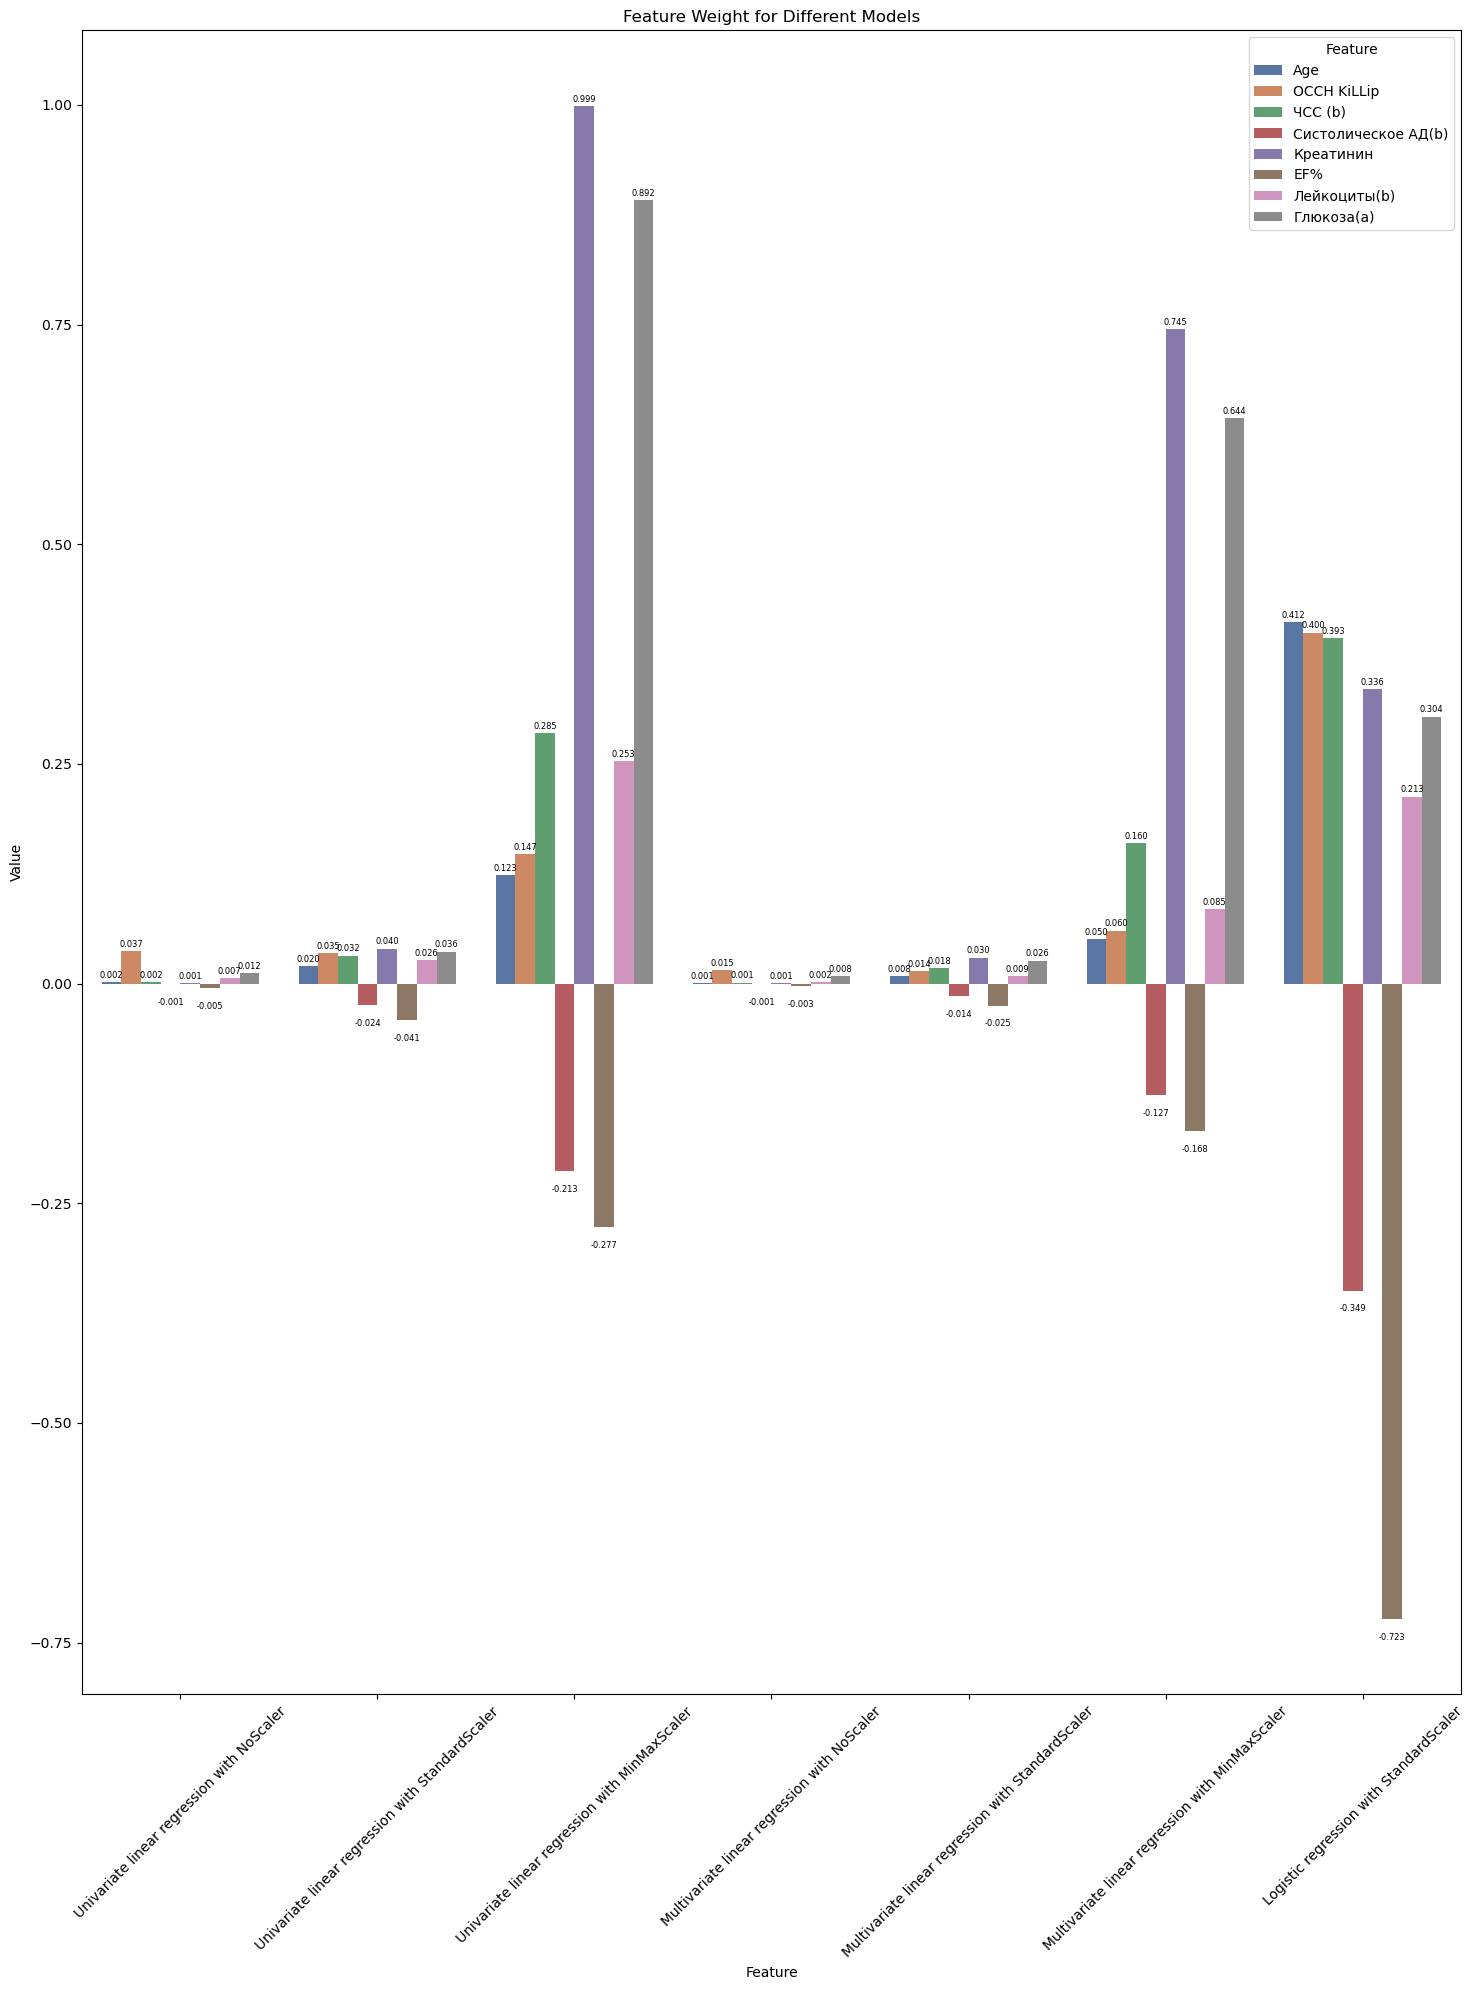

In [53]:
plot_values(flatten_df(combined_weights_regression_df), "Weight")

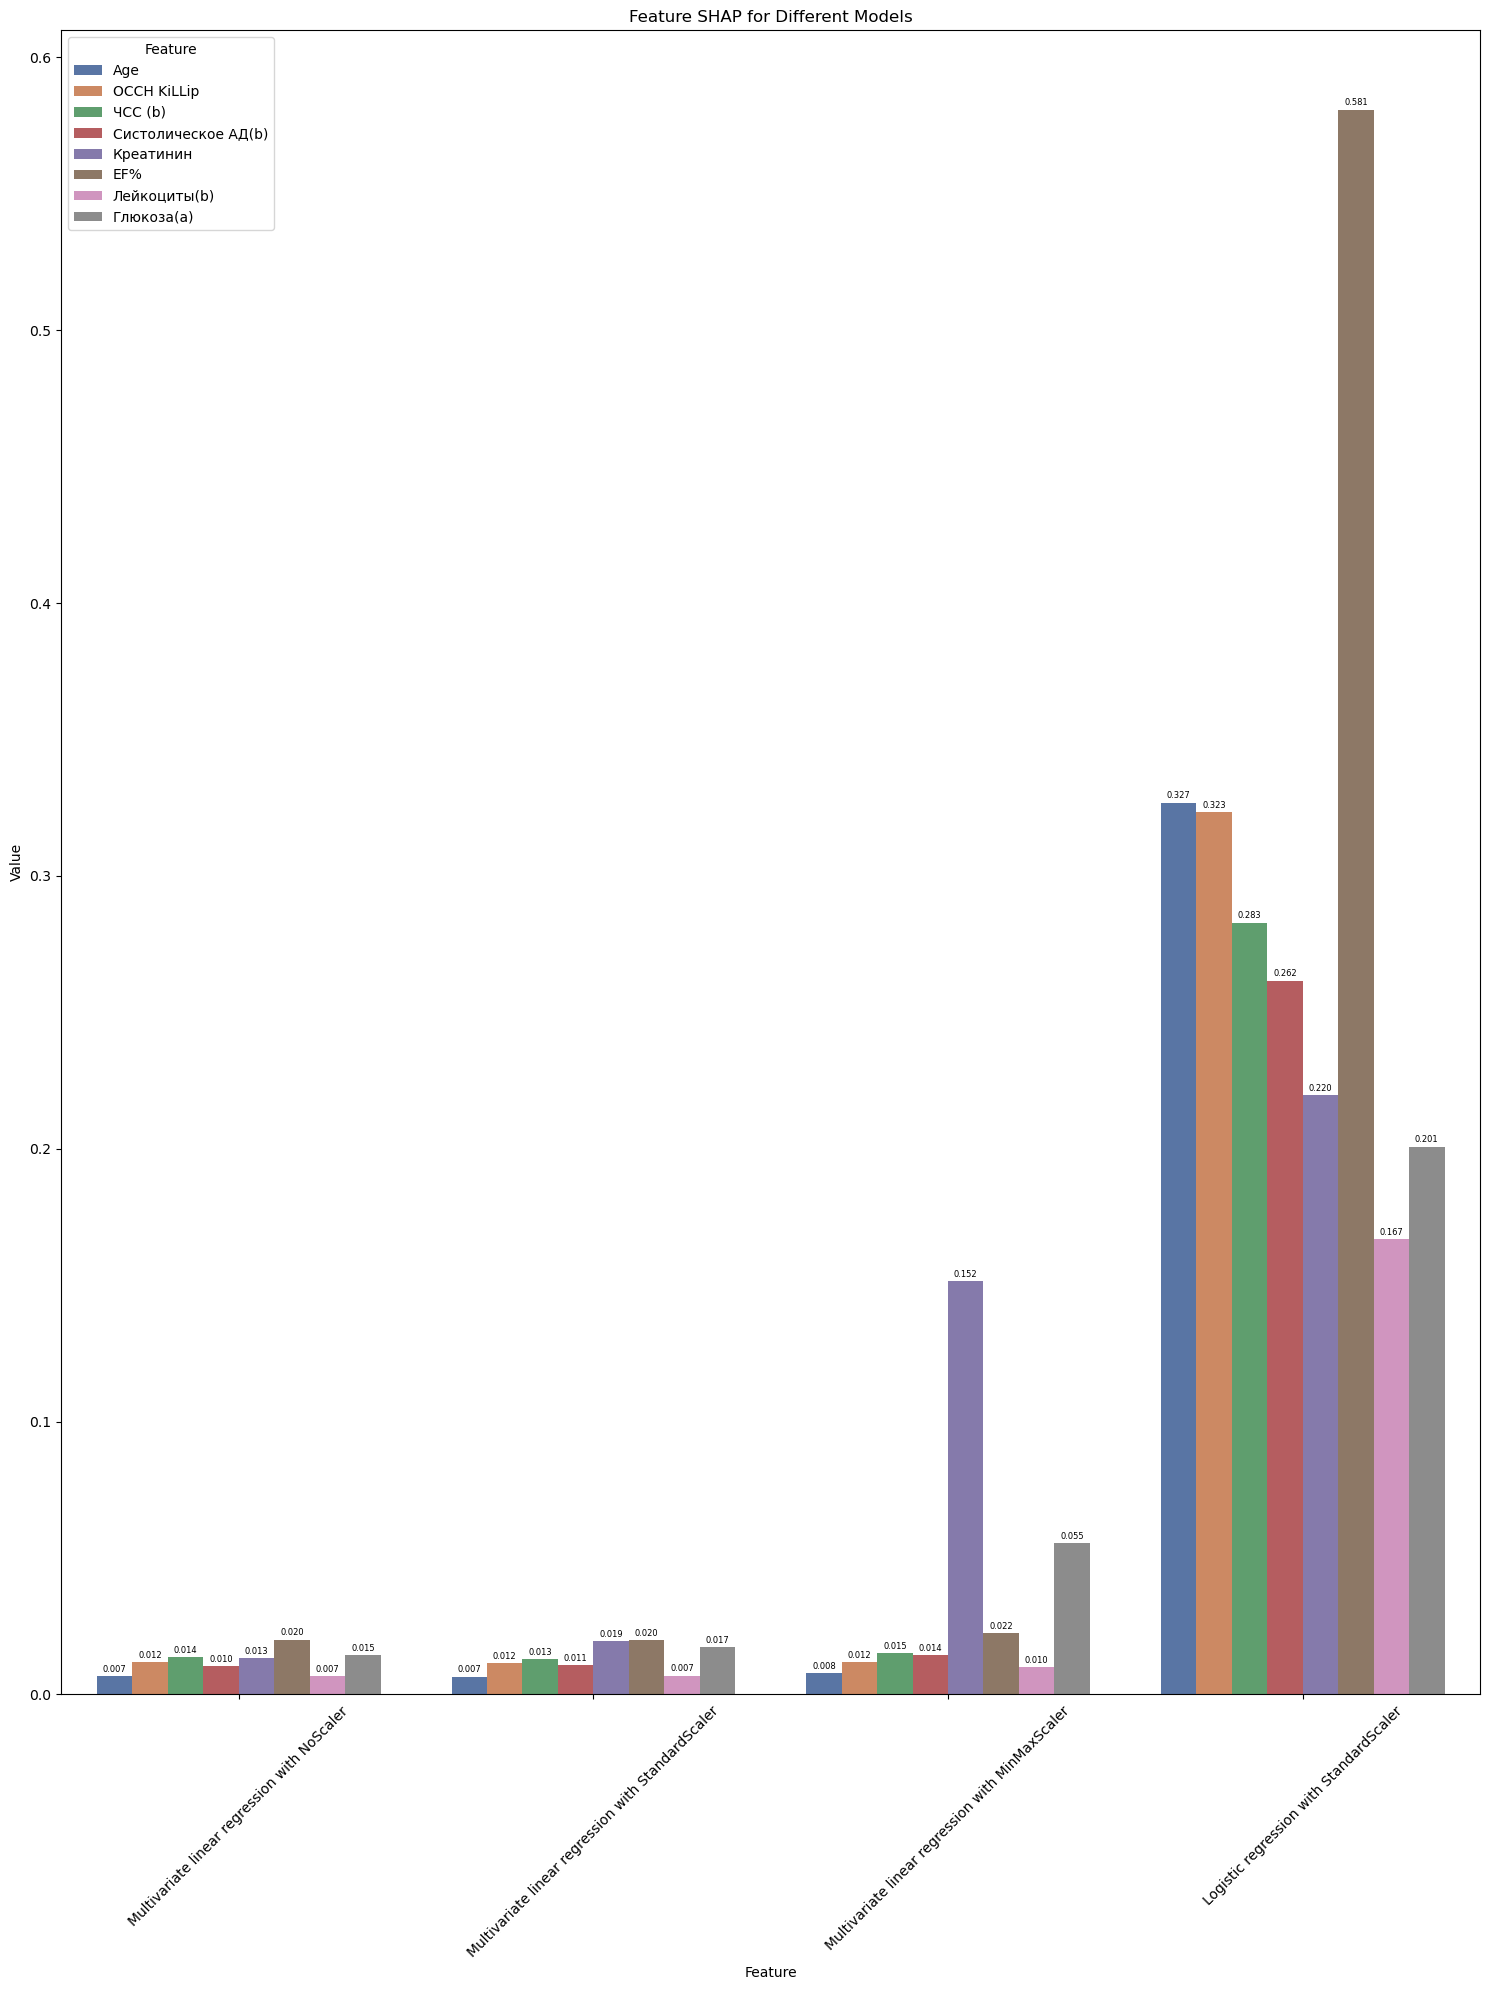

In [54]:
plot_values(flatten_df(combined_weights_regression_df), "SHAP")

5. Gradient Boosting model

In [55]:
combined_weights_tree_df = None #this df contains weights of features calculated for tree based models

In [56]:
import xgboost as xgb

def perform_xgboost_regression(scaled_data, model_info=''):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=25)
    xgb_model.fit(scaled_data['X_train'], y_train)
    

    # Feature importance using XGBoost's built-in feature importance metric
    feature_importances = xgb_model.feature_importances_

    # Shapley values for XGBoost Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(xgb_model, 
                                                        scaled_data, 
                                                        shap_algorithm='tree')

    weights_df = create_weights_df(feature_importances,
                                    model_info=f'XGBoost regression - {model_info}',
                                    index_columns=scaled_data['X_train'].columns,
                                    shap_values=mean_abs_shap_values)
    return weights_df

6. Random Forest model

In [57]:
def perform_forest_regression(scaled_data, model_info=''):
    rf_model = RandomForestRegressor(n_jobs=-1, random_state=25)
    rf_model.fit(scaled_data['X_train'], y_train)

    # Feature importance using RandomForest's built-in feature importance metric
    feature_importances = rf_model.feature_importances_

    # Shapley values for RandomForest Regression
    mean_abs_shap_values = compute_mean_abs_shap_values(rf_model, 
                                                        scaled_data, 
                                                        shap_algorithm='tree')

    weights_df = create_weights_df(feature_importances,
                                    model_info=f'RandomForest regression - {model_info}',
                                    index_columns=scaled_data['X_train'].columns,
                                    shap_values=mean_abs_shap_values)
    return weights_df

This function will change the order of columns for our tree models

In [58]:
def carousel_wrapper(scaled_data, model_function, model_info=''):
    n_columns = len(scaled_data['X_train'].columns)
    all_weights_df = []

    for i in range(n_columns):
        # Rotate columns based on round-robin principle
        rotated_columns = np.roll(scaled_data['X_train'].columns, shift=-i)
        
        # Rearrange the columns in the dataset
        rotated_data = {}
        for key in scaled_data:
            # Assign the rotated columns to the data
            rotated_data[key] = scaled_data[key][rotated_columns]

        # Call the provided model_function with the new order of columns
        weights_df = model_function(rotated_data, model_info=f'{model_info} - Rotation {i+1}')
        all_weights_df.append(weights_df)
    
    # Combine all the weights dataframes into a single dataframe using join
    combined_weights_df = all_weights_df[0].join(all_weights_df[1:])

    return combined_weights_df


In [59]:
xgboost_weights_shap_df = carousel_wrapper(original_set, perform_xgboost_regression)

In [60]:
display(xgboost_weights_shap_df)
display(xgboost_weights_shap_df.describe())

XGBoost regression -  - Rotation 1            \
                                                Weight      SHAP   
Age                                           0.107133  0.012882   
ОССН KiLLip                                   0.069323  0.005511   
ЧСС (b)                                       0.108464  0.015436   
Систолическое АД(b)                           0.158001  0.010665   
Креатинин                                     0.106279  0.011443   
EF%                                           0.228505  0.011483   
Лейкоциты(b)                                  0.097871  0.009981   
Глюкоза(a)                                    0.124424  0.012951   

                    XGBoost regression -  - Rotation 2            \
                                                Weight      SHAP   
Age                                           0.143196  0.011453   
ОССН KiLLip                                   0.065591  0.007365   
ЧСС (b)                                       0.103631  0.016760   
Систолическое АД(b)                           0.152645  0.010371   
Креатинин                                     0.103832  0.013057   
EF%                                           0.248584  0.010969   
Лейкоциты(b)                                  0.069388  0.008023   
Глюкоза(a)                                    0.113133  0.014894   

                    XGBoost regression -  - Rotation 3            \
                                                Weight      SHAP   
Age                                           0.143586  0.011625   
ОССН KiLLip                                   0.088204  0.006781   
ЧСС (b)                                       0.089813  0.017353   
Систолическое АД(b)                           0.142394  0.010784   
Креатинин                                     0.104962  0.013065   
EF%                                           0.250525  0.010993   
Лейкоциты(b)                                  0.068360  0.008172   
Глюкоза(a)                                    0.112156  0.015364   

                    XGBoost regression -  - Rotation 4            \
                                                Weight      SHAP   
Age                                           0.151160  0.010715   
ОССН KiLLip                                   0.070480  0.007617   
ЧСС (b)                                       0.126501  0.016328   
Систолическое АД(b)                           0.120297  0.008423   
Креатинин                                     0.108208  0.013720   
EF%                                           0.213470  0.010912   
Лейкоциты(b)                                  0.087759  0.009838   
Глюкоза(a)                                    0.122126  0.015600   

                    XGBoost regression -  - Rotation 5            \
                                                Weight      SHAP   
Age                                           0.143669  0.010691   
ОССН KiLLip                                   0.066623  0.007661   
ЧСС (b)                                       0.121608  0.016327   
Систолическое АД(b)                           0.187950  0.008414   
Креатинин                                     0.094336  0.013661   
EF%                                           0.189545  0.010810   
Лейкоциты(b)                                  0.079626  0.009704   
Глюкоза(a)                                    0.116645  0.014552   

                    XGBoost regression -  - Rotation 6            \
                                                Weight      SHAP   
Age                                           0.141494  0.010741   
ОССН KiLLip                                   0.068399  0.007489   
ЧСС (b)                                       0.123063  0.016263   
Систолическое АД(b)                           0.199847  0.008996   
Креатинин                                     0.123898  0.013958   
EF%                                           0.149759  0.011697   
Лейкоциты(b)                                  0.075793  0.009512   
Глю

XGBoost regression -  - Rotation 1            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011294   
std                             0.048670  0.002879   
min                             0.069323  0.005511   
25%                             0.104177  0.010494   
50%                             0.107799  0.011463   
75%                             0.132818  0.012899   
max                             0.228505  0.015436   

      XGBoost regression -  - Rotation 2            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011611   
std                             0.058598  0.003213   
min                             0.065591  0.007365   
25%                             0.095070  0.009784   
50%                             0.108483  0.011211   
75%                             0.145558  0.013516   
max                             0.248584  0.016760   

      XGBoost regression -  - Rotation 3            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011767   
std                             0.057035  0.003489   
min                             0.068360  0.006781   
25%                             0.089411  0.010131   
50%                             0.108559  0.011309   
75%                             0.142692  0.013639   
max                             0.250525  0.017353   

      XGBoost regression -  - Rotation 4            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011644   
std                             0.043400  0.003233   
min                             0.070480  0.007617   
25%                             0.103096  0.009484   
50%                             0.121211  0.010814   
75%                             0.132666  0.014190   
max                             0.213470  0.016328   

      XGBoost regression -  - Rotation 5            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011478   
std                             0.046238  0.003068   
min                             0.066623  0.007661   
25%                             0.090658  0.009381   
50%                             0.119126  0.010751   
75%                             0.154739  0.013884   
max                             0.189545  0.016327   

      XGBoost regression -  - Rotation 6            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011748   
std                             0.041696  0.003157   
min                             0.068399  0.007489   
25%                             0.107259  0.009383   
50%                             0.123480  0.011219   
75%                             0.143560  0.014299   
max                             0.199847  0.016263   

      XGBoost regression -  - Rotation 7            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011746   
std                             0.054438  0.003304   
min                             0.063941  0.007897   
25%                             0.095351  0.009278   
50%                             0.112444  0.010730   
75%                             0.148488  0.014601   
max                             0.222389  0.016389   

      XGBoost regression -  - Rotation 8            
                                  Weight      SHAP  
count                           8.000000  8.000000  
mean                            0.125000  0.011546  
std    

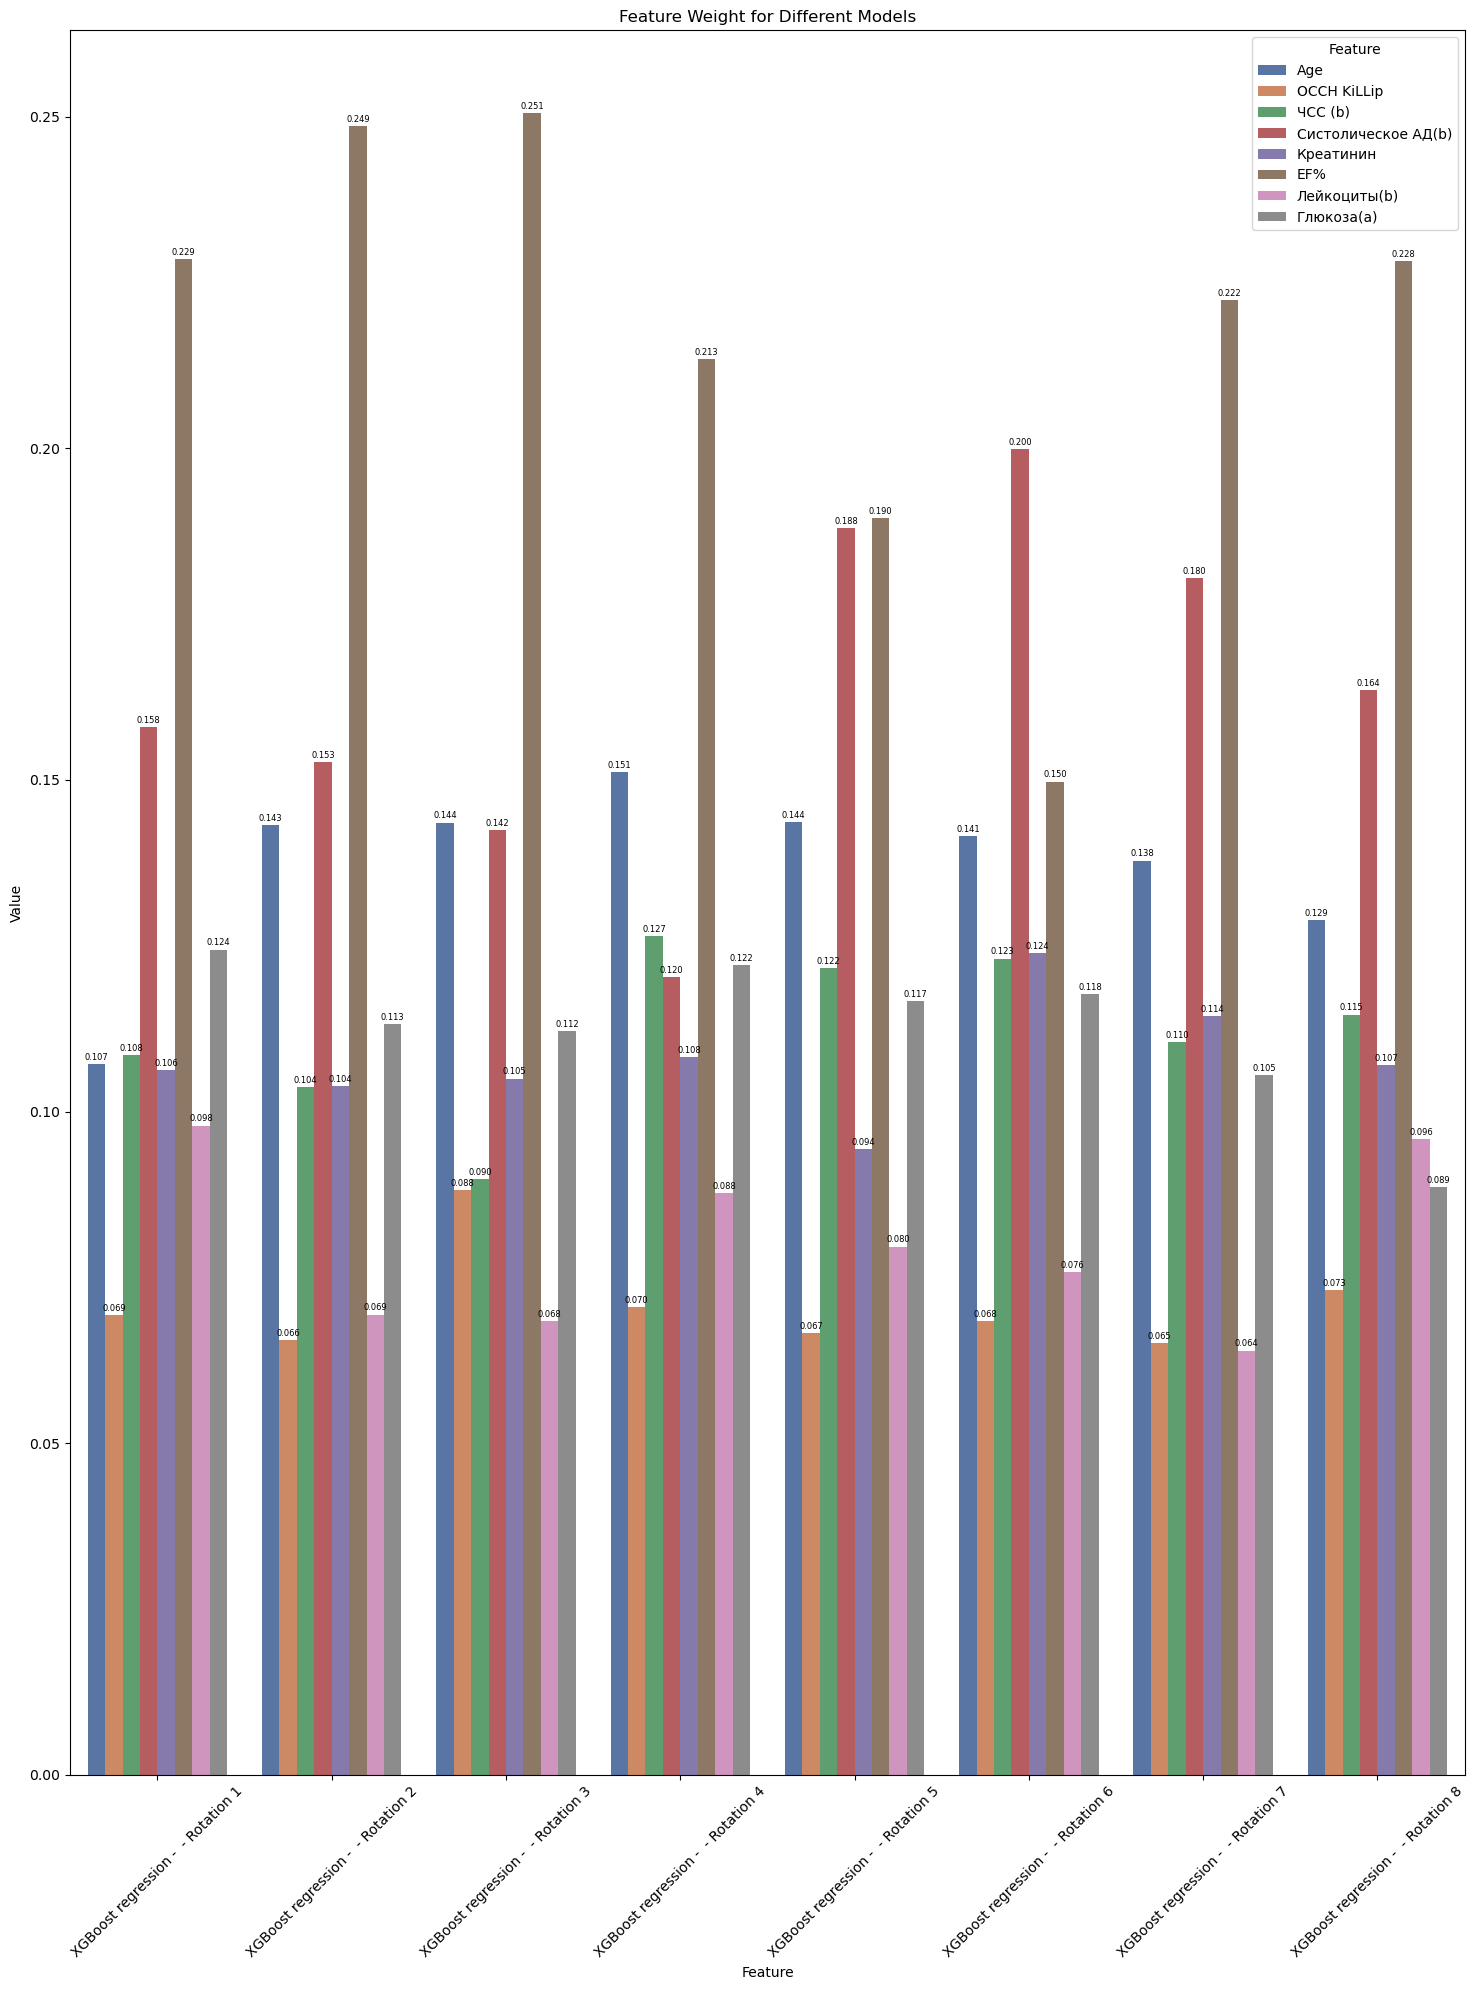

In [61]:
plot_values(flatten_df(xgboost_weights_shap_df), "Weight")

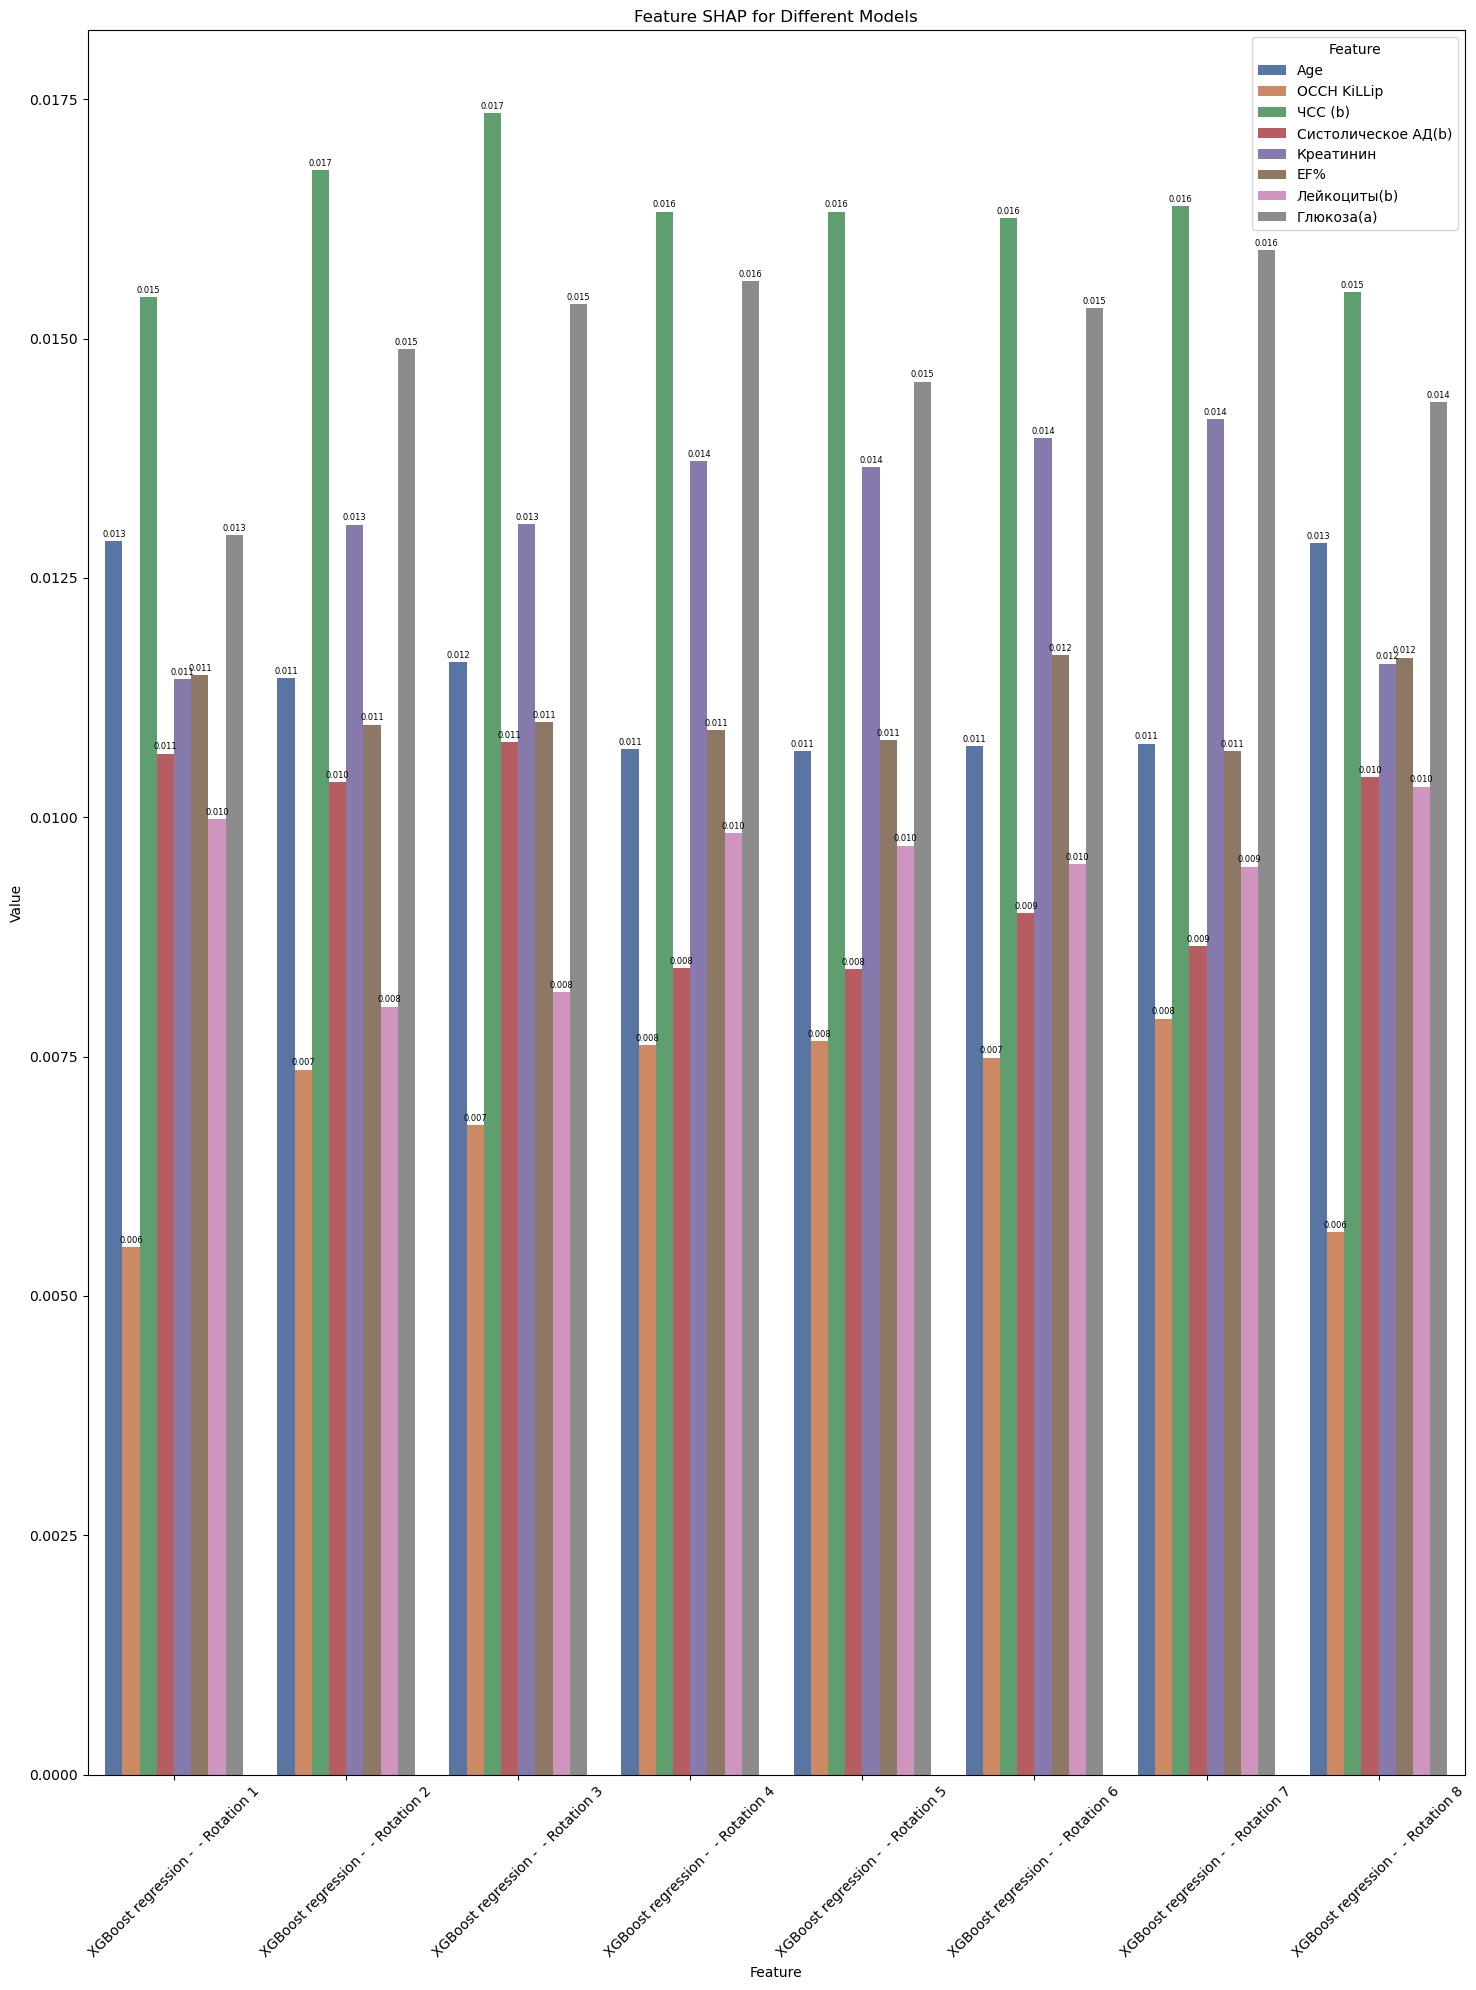

In [62]:
plot_values(flatten_df(xgboost_weights_shap_df), "SHAP")

In [63]:
forest_weights_shap_df = carousel_wrapper(original_set, perform_forest_regression)

In [64]:
display(forest_weights_shap_df)
display(forest_weights_shap_df.describe())

RandomForest regression -  - Rotation 1            \
                                                     Weight      SHAP   
Age                                                0.108425  0.009103   
ОССН KiLLip                                        0.033975  0.006826   
ЧСС (b)                                            0.106713  0.014292   
Систолическое АД(b)                                0.106710  0.007791   
Креатинин                                          0.163973  0.007424   
EF%                                                0.173347  0.010225   
Лейкоциты(b)                                       0.121952  0.008404   
Глюкоза(a)                                         0.184906  0.011753   

                    RandomForest regression -  - Rotation 2            \
                                                     Weight      SHAP   
Age                                                0.108610  0.009284   
ОССН KiLLip                                        0.035156  0.006788   
ЧСС (b)                                            0.107955  0.014057   
Систолическое АД(b)                                0.105339  0.007658   
Креатинин                                          0.163806  0.007877   
EF%                                                0.170444  0.010607   
Лейкоциты(b)                                       0.123697  0.008172   
Глюкоза(a)                                         0.184994  0.011877   

                    RandomForest regression -  - Rotation 3            \
                                                     Weight      SHAP   
Age                                                0.109482  0.009077   
ОССН KiLLip                                        0.035090  0.006632   
ЧСС (b)                                            0.107345  0.014444   
Систолическое АД(b)                                0.104024  0.007678   
Креатинин                                          0.164620  0.007685   
EF%                                                0.170798  0.010650   
Лейкоциты(b)                                       0.124183  0.008506   
Глюкоза(a)                                         0.184458  0.011537   

                    RandomForest regression -  - Rotation 4            \
                                                     Weight      SHAP   
Age                                                0.110369  0.009076   
ОССН KiLLip                                        0.036308  0.006897   
ЧСС (b)                                            0.105445  0.013828   
Систолическое АД(b)                                0.106245  0.007846   
Креатинин                                          0.159586  0.007528   
EF%                                                0.173986  0.010608   
Лейкоциты(b)                                       0.121657  0.008146   
Глюкоза(a)                                         0.186405  0.011416   

                    RandomForest regression -  - Rotation 5            \
                                                     Weight      SHAP   
Age                                                0.110892  0.008946   
ОССН KiLLip                                        0.036115  0.007069   
ЧСС (b)                                            0.107733  0.014072   
Систолическое АД(b)                                0.104650  0.007689   
Креатинин                                          0.163580  0.007643   
EF%                                                0.170624  0.010645   
Лейкоциты(b)                                       0.121816  0.008739   
Глюкоза(a)                                         0.184590  0.011897   

                    RandomForest regression -  - Rotation 6            \
                                                     Weight      SHAP   
Age                                                0.108640  0.009462   
ОССН KiLLip                                        0.034424  0.007109   
ЧСС (b)                                            0.108030  0.013908   


RandomForest regression -  - Rotation 1            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009477   
std                                  0.048820  0.002516   
min                                  0.033975  0.006826   
25%                                  0.106712  0.007700   
50%                                  0.115189  0.008754   
75%                                  0.166316  0.010607   
max                                  0.184906  0.014292   

      RandomForest regression -  - Rotation 2            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009540   
std                                  0.048092  0.002473   
min                                  0.035156  0.006788   
25%                                  0.107301  0.007822   
50%                                  0.116153  0.008728   
75%                                  0.165466  0.010924   
max                                  0.184994  0.014057   

      RandomForest regression -  - Rotation 3            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009526   
std                                  0.048225  0.002561   
min                                  0.035090  0.006632   
25%                                  0.106515  0.007683   
50%                                  0.116832  0.008791   
75%                                  0.166165  0.010871   
max                                  0.184458  0.014444   

      RandomForest regression -  - Rotation 4            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009418   
std                                  0.048095  0.002360   
min                                  0.036308  0.006897   
25%                                  0.106045  0.007767   
50%                                  0.116013  0.008611   
75%                                  0.163186  0.010810   
max                                  0.186405  0.013828   

      RandomForest regression -  - Rotation 5            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009588   
std                                  0.047724  0.002433   
min                                  0.036115  0.007069   
25%                                  0.106962  0.007677   
50%                                  0.116354  0.008843   
75%                                  0.165341  0.010958   
max                                  0.184590  0.014072   

      RandomForest regression -  - Rotation 6            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009538   
std                                  0.048295  0.002411   
min                                  0.034424  0.007109   
25%                                  0.107240  0.007467   
50%                                  0.116906  0.008977   
75%                                  0.164311  0.011148   
max                                  0.184195  0.013908   

      RandomForest regression -  - Rotation 7            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009550   
std                                  0.048316  0.002445   
min                                  0.035696  0.006844   
25%                                  0.106981  0.007707   
50%                                  0.115192  

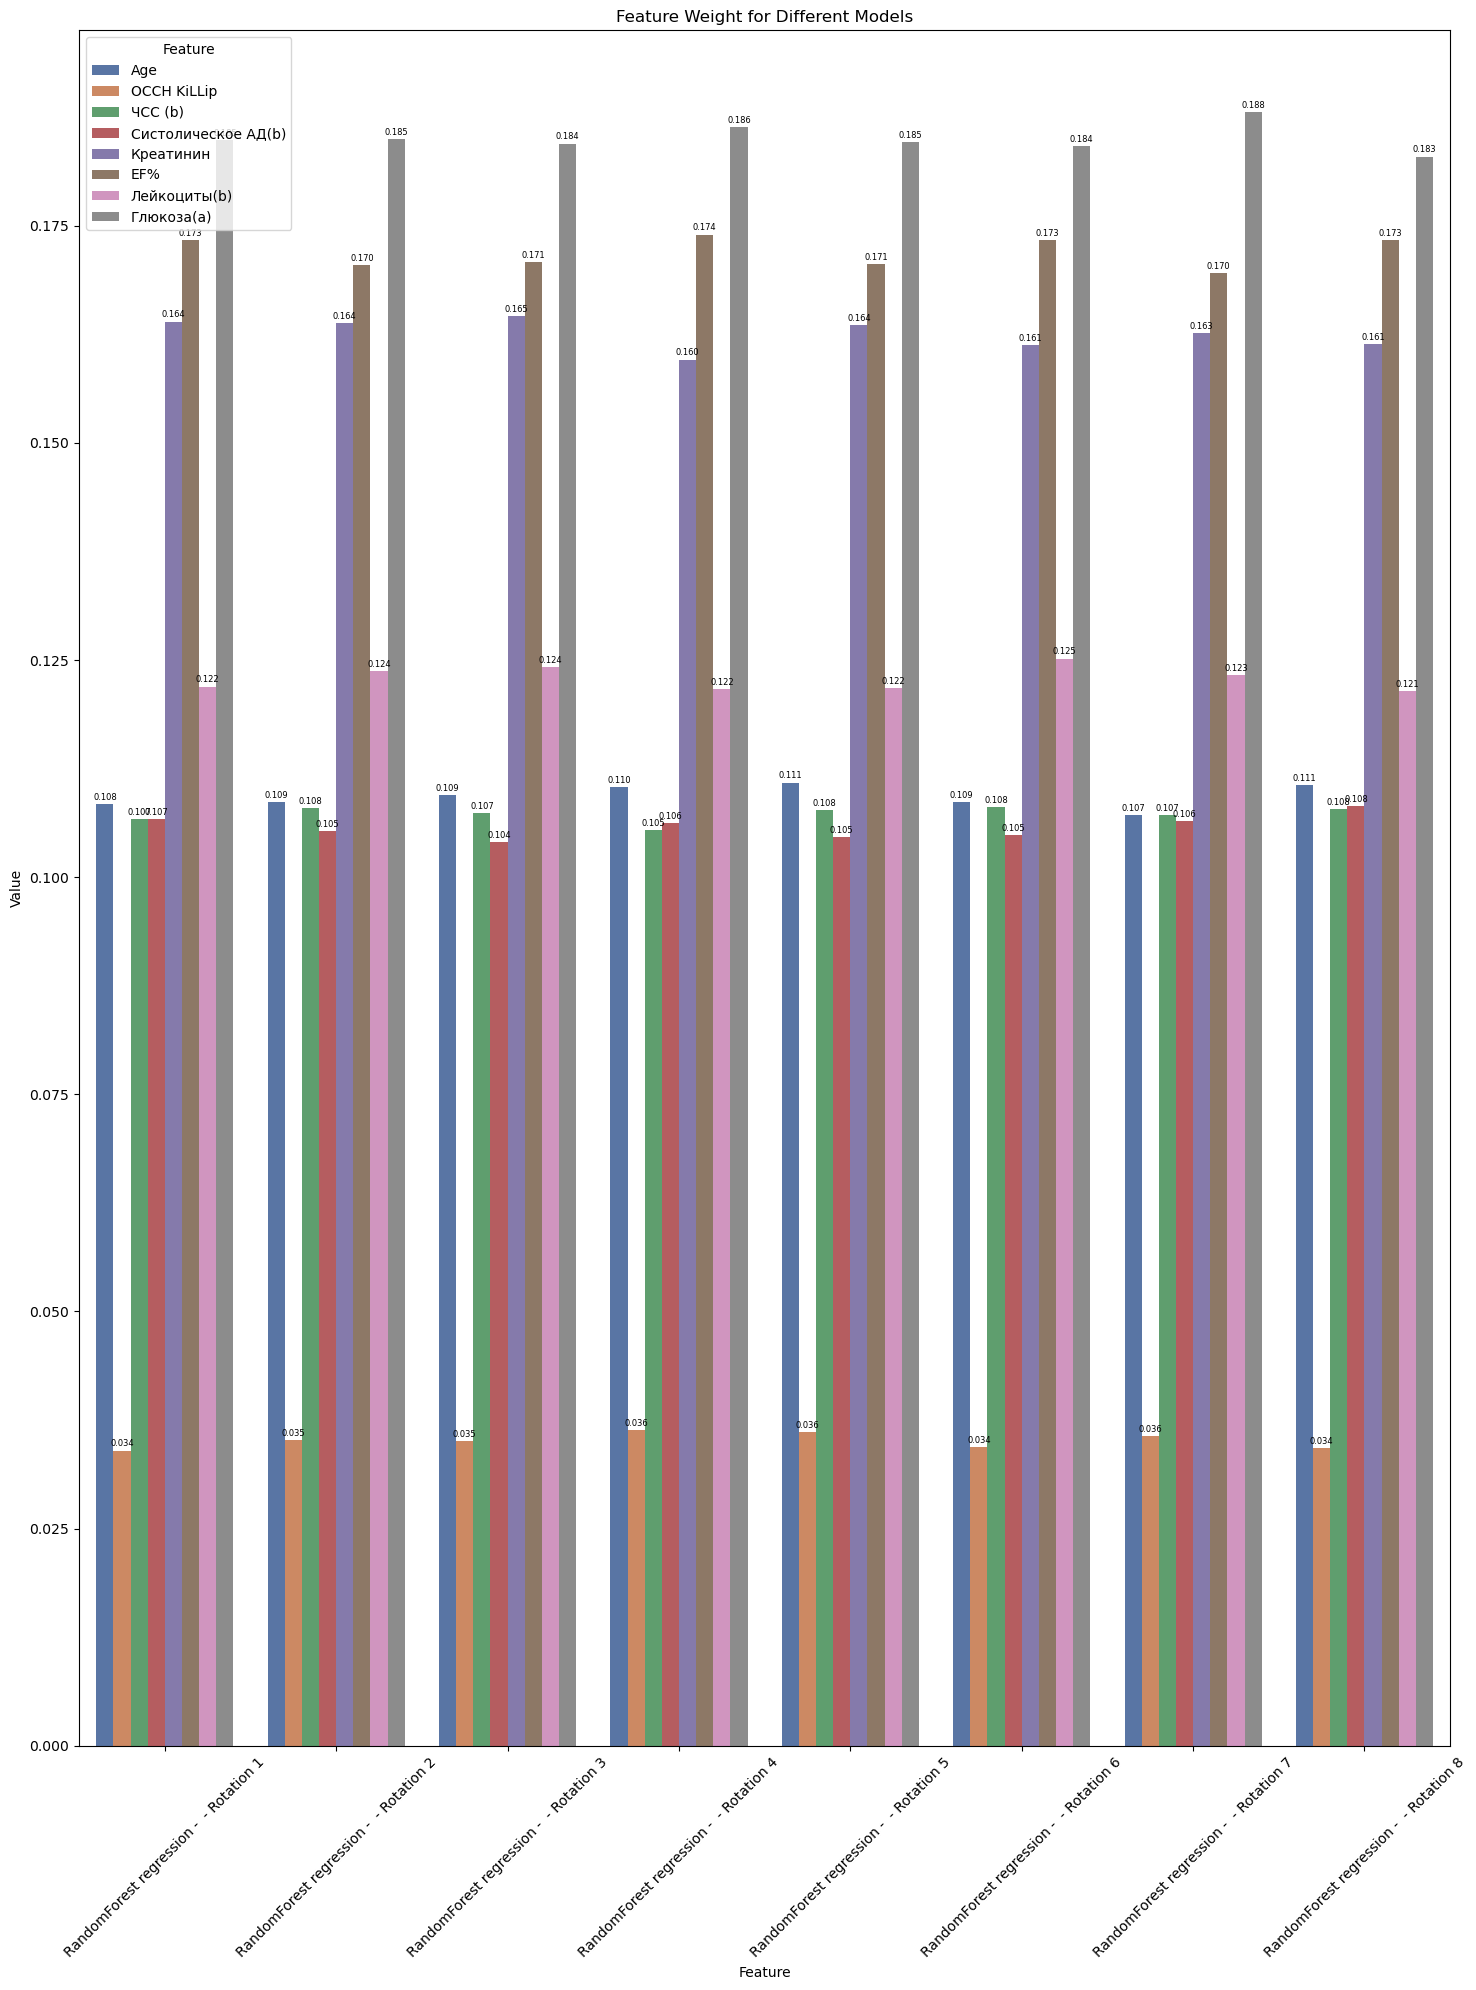

In [65]:
plot_values(flatten_df(forest_weights_shap_df), "Weight")

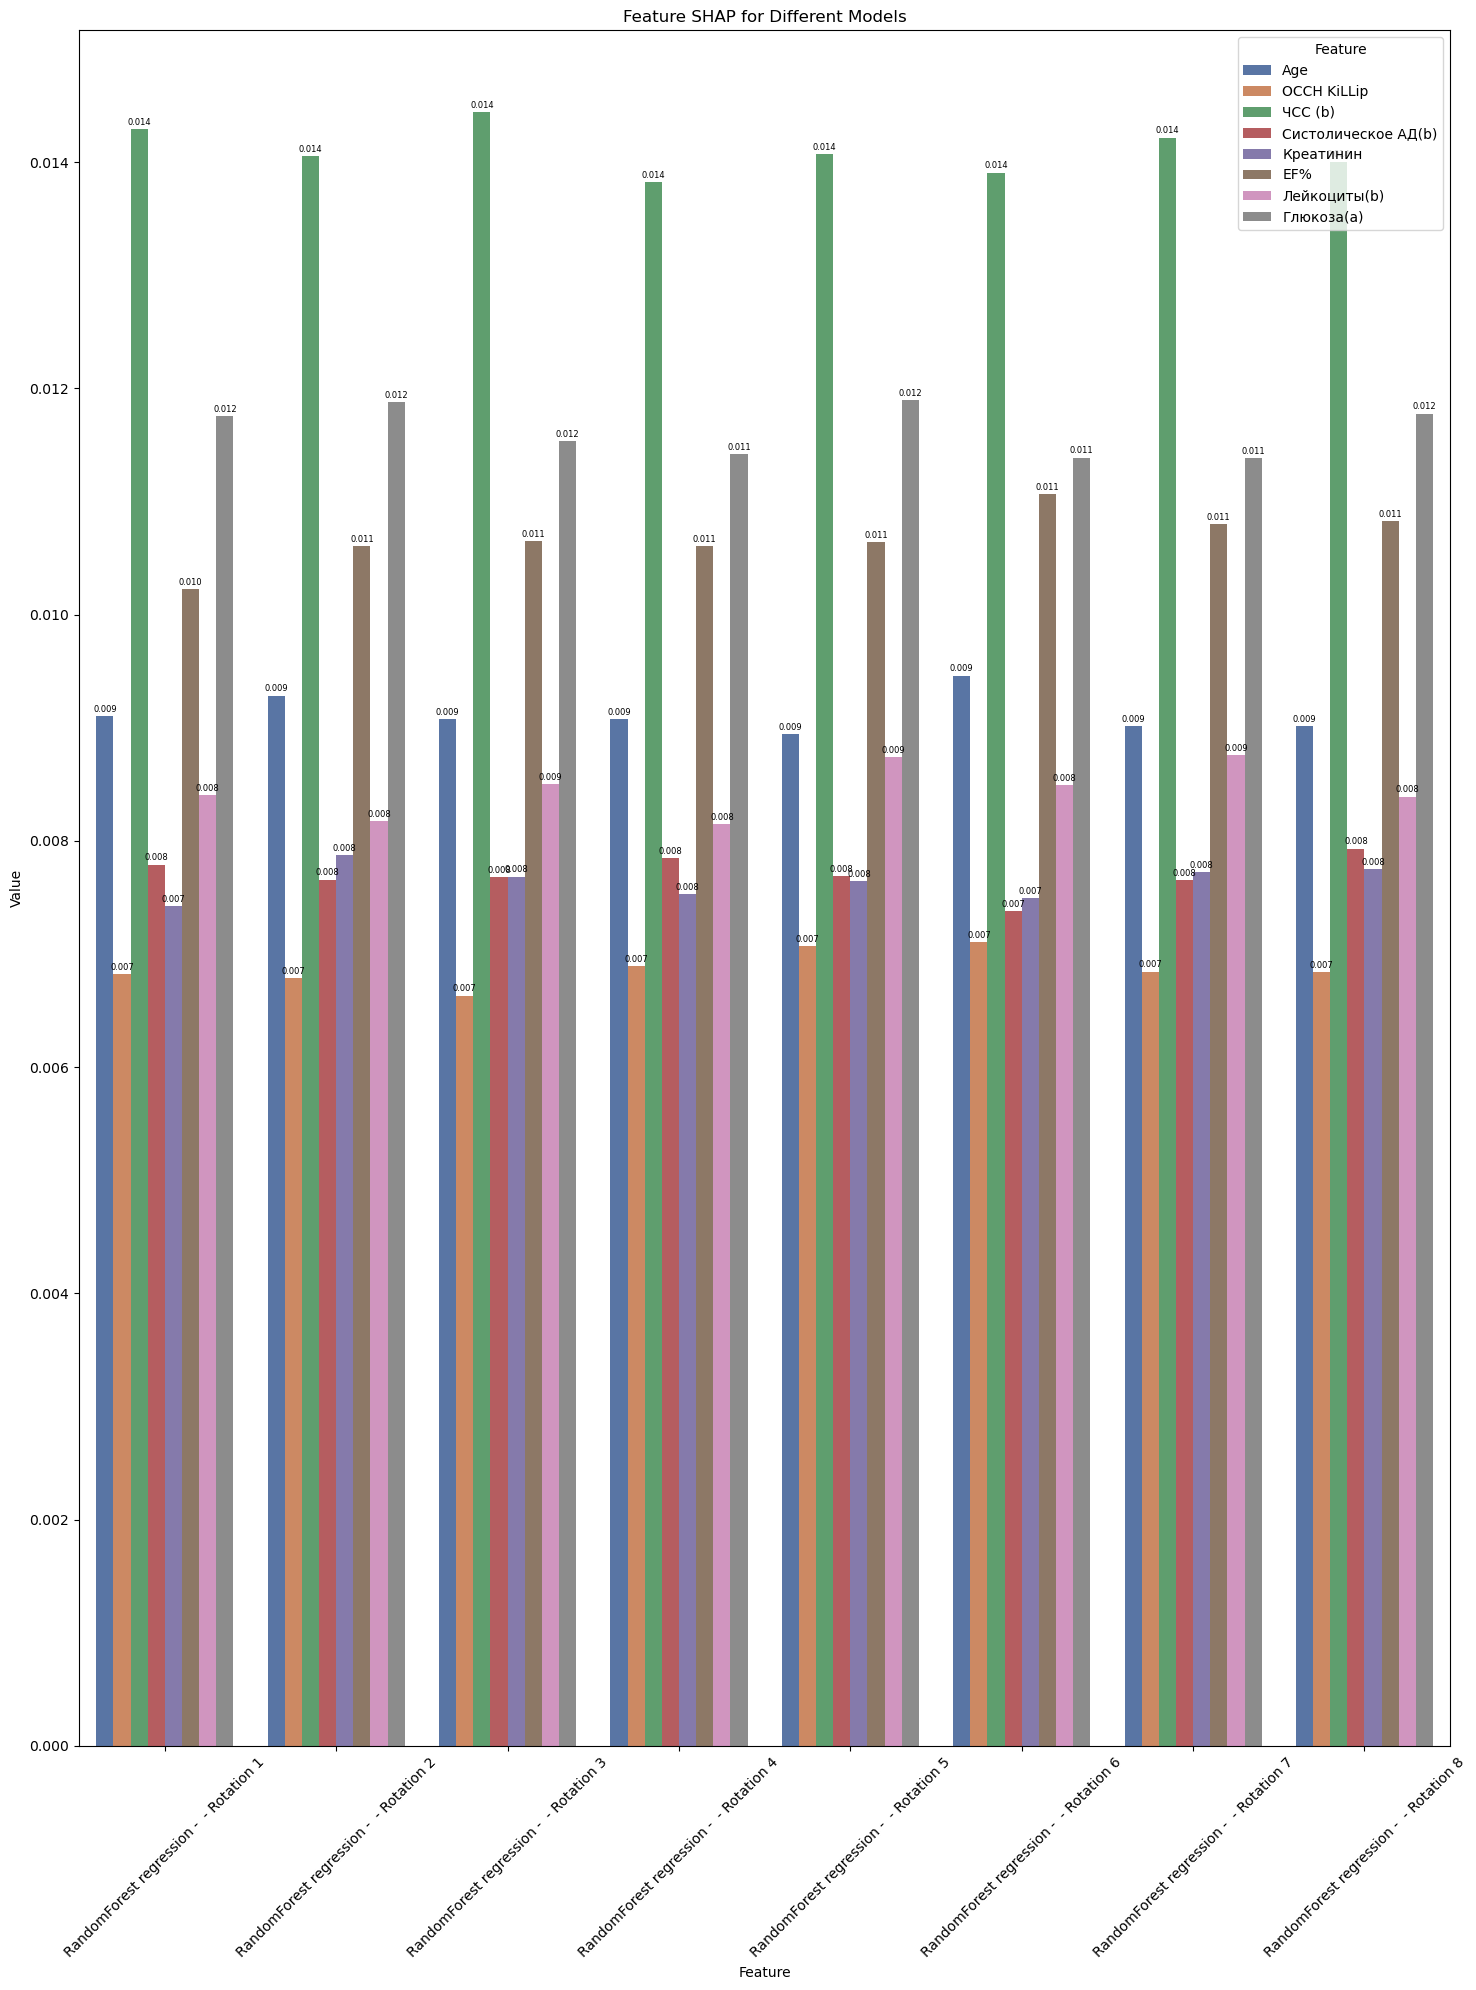

In [66]:
plot_values(flatten_df(forest_weights_shap_df), "SHAP")

In [67]:
combined_weights_tree_df = pd.concat([xgboost_weights_shap_df,
                                      forest_weights_shap_df
                                 ], axis=1)

In [68]:
display(combined_weights_tree_df)
display(combined_weights_tree_df.describe())

XGBoost regression -  - Rotation 1            \
                                                Weight      SHAP   
Age                                           0.107133  0.012882   
ОССН KiLLip                                   0.069323  0.005511   
ЧСС (b)                                       0.108464  0.015436   
Систолическое АД(b)                           0.158001  0.010665   
Креатинин                                     0.106279  0.011443   
EF%                                           0.228505  0.011483   
Лейкоциты(b)                                  0.097871  0.009981   
Глюкоза(a)                                    0.124424  0.012951   

                    XGBoost regression -  - Rotation 2            \
                                                Weight      SHAP   
Age                                           0.143196  0.011453   
ОССН KiLLip                                   0.065591  0.007365   
ЧСС (b)                                       0.103631  0.016760   
Систолическое АД(b)                           0.152645  0.010371   
Креатинин                                     0.103832  0.013057   
EF%                                           0.248584  0.010969   
Лейкоциты(b)                                  0.069388  0.008023   
Глюкоза(a)                                    0.113133  0.014894   

                    XGBoost regression -  - Rotation 3            \
                                                Weight      SHAP   
Age                                           0.143586  0.011625   
ОССН KiLLip                                   0.088204  0.006781   
ЧСС (b)                                       0.089813  0.017353   
Систолическое АД(b)                           0.142394  0.010784   
Креатинин                                     0.104962  0.013065   
EF%                                           0.250525  0.010993   
Лейкоциты(b)                                  0.068360  0.008172   
Глюкоза(a)                                    0.112156  0.015364   

                    XGBoost regression -  - Rotation 4            \
                                                Weight      SHAP   
Age                                           0.151160  0.010715   
ОССН KiLLip                                   0.070480  0.007617   
ЧСС (b)                                       0.126501  0.016328   
Систолическое АД(b)                           0.120297  0.008423   
Креатинин                                     0.108208  0.013720   
EF%                                           0.213470  0.010912   
Лейкоциты(b)                                  0.087759  0.009838   
Глюкоза(a)                                    0.122126  0.015600   

                    XGBoost regression -  - Rotation 5            ...  \
                                                Weight      SHAP  ...   
Age                                           0.143669  0.010691  ...   
ОССН KiLLip                                   0.066623  0.007661  ...   
ЧСС (b)                                       0.121608  0.016327  ...   
Систолическое АД(b)                           0.187950  0.008414  ...   
Креатинин                                     0.094336  0.013661  ...   
EF%                                           0.189545  0.010810  ...   
Лейкоциты(b)                                  0.079626  0.009704  ...   
Глюкоза(a)                                    0.116645  0.014552  ...   

                    RandomForest regression -  - Rotation 4            \
                                                     Weight      SHAP   
Age                                                0.110369  0.009076   
ОССН KiLLip                                        0.036308  0.006897   
ЧСС (b)                                            0.105445  0.013828   
Систолическое АД(b)                                0.106245  0.007846   
Креатинин                                          0.159586  0.007528   
EF%                                                0.1

XGBoost regression -  - Rotation 1            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011294   
std                             0.048670  0.002879   
min                             0.069323  0.005511   
25%                             0.104177  0.010494   
50%                             0.107799  0.011463   
75%                             0.132818  0.012899   
max                             0.228505  0.015436   

      XGBoost regression -  - Rotation 2            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011611   
std                             0.058598  0.003213   
min                             0.065591  0.007365   
25%                             0.095070  0.009784   
50%                             0.108483  0.011211   
75%                             0.145558  0.013516   
max                             0.248584  0.016760   

      XGBoost regression -  - Rotation 3            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011767   
std                             0.057035  0.003489   
min                             0.068360  0.006781   
25%                             0.089411  0.010131   
50%                             0.108559  0.011309   
75%                             0.142692  0.013639   
max                             0.250525  0.017353   

      XGBoost regression -  - Rotation 4            \
                                  Weight      SHAP   
count                           8.000000  8.000000   
mean                            0.125000  0.011644   
std                             0.043400  0.003233   
min                             0.070480  0.007617   
25%                             0.103096  0.009484   
50%                             0.121211  0.010814   
75%                             0.132666  0.014190   
max                             0.213470  0.016328   

      XGBoost regression -  - Rotation 5            ...  \
                                  Weight      SHAP  ...   
count                           8.000000  8.000000  ...   
mean                            0.125000  0.011478  ...   
std                             0.046238  0.003068  ...   
min                             0.066623  0.007661  ...   
25%                             0.090658  0.009381  ...   
50%                             0.119126  0.010751  ...   
75%                             0.154739  0.013884  ...   
max                             0.189545  0.016327  ...   

      RandomForest regression -  - Rotation 4            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009418   
std                                  0.048095  0.002360   
min                                  0.036308  0.006897   
25%                                  0.106045  0.007767   
50%                                  0.116013  0.008611   
75%                                  0.163186  0.010810   
max                                  0.186405  0.013828   

      RandomForest regression -  - Rotation 5            \
                                       Weight      SHAP   
count                                8.000000  8.000000   
mean                                 0.125000  0.009588   
std                                  0.047724  0.002433   
min                                  0.036115  0.007069   
25%                                  0.106962  0.007677   
50%                                  0.116354  0.008843   
75%                                  0.165341  0.010958   
max                                  0.184590  0.014072   

      RandomForest regression -  - Rotation 6            \
          

7. Deep Neural Network model

In [71]:
# Define model architecture
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
76/76 [==============================] - 3s 15ms/step - loss: 17.5955 - val_loss: 0.0370
Epoch 2/100
76/76 [==============================] - 1s 7ms/step - loss: 0.0721 - val_loss: 0.0367
Epoch 3/100
76/76 [==============================] - 1s 7ms/step - loss: 0.1218 - val_loss: 0.0366
Epoch 4/100
76/76 [==============================] - 1s 7ms/step - loss: 0.0565 - val_loss: 0.0366
Epoch 5/100
76/76 [==============================] - 0s 6ms/step - loss: 0.0368 - val_loss: 0.0366
Epoch 6/100
76/76 [==============================] - 1s 9ms/step - loss: 0.0412 - val_loss: 0.0367
Epoch 7/100
76/76 [==============================] - 1s 8ms/step - loss: 0.0384 - val_loss: 0.0366
Epoch 8/100
76/76 [==============================] - 1s 10ms/step - loss: 0.0331 - val_loss: 0.0366
Epoch 9/100
76/76 [==============================] - 1s 7ms/step - loss: 0.0349 - val_loss: 0.0366
Epoch 10/100
76/76 [==============================] - 1s 9ms/step - loss: 0.0360 - val_loss: 0.0366
Epoch 

In [72]:
shap_algorithm = 'partition'  
mean_abs_shap_values = compute_mean_abs_shap_values(model, std_set, shap_algorithm)

# Create a DataFrame to display feature importances
feature_importances = pd.DataFrame(mean_abs_shap_values, index=X.columns, columns=["SHAP Values"])
#feature_importances.sort_values(by="SHAP Values", ascending=False, inplace=True)

# Display feature importances
display(feature_importances)

25/25 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


Partition explainer:   0%|          | 2/605 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   1%|          | 4/605 [00:17<26:45,  2.67s/it]

13/13 [==============================] - 0s 2ms/step


Partition explainer:   1%|          | 5/605 [00:22<36:06,  3.61s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   1%|          | 6/605 [00:27<41:25,  4.15s/it]

25/25 [==============================] - 0s 2ms/step


Partition explainer:   1%|          | 7/605 [00:32<44:29,  4.46s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   1%|▏         | 8/605 [00:37<45:27,  4.57s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   1%|▏         | 9/605 [00:42<45:06,  4.54s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   2%|▏         | 10/605 [00:47<46:21,  4.68s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   2%|▏         | 11/605 [00:52<47:56,  4.84s/it]

13/13 [==============================] - 0s 2ms/step


Partition explainer:   2%|▏         | 12/605 [00:57<48:38,  4.92s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   2%|▏         | 13/605 [01:02<49:01,  4.97s/it]

25/25 [==============================] - 0s 7ms/step


Partition explainer:   2%|▏         | 14/605 [01:07<48:03,  4.88s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   2%|▏         | 15/605 [01:11<45:52,  4.67s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   3%|▎         | 16/605 [01:16<45:56,  4.68s/it]

32/32 [==============================] - 0s 2ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:   3%|▎         | 17/605 [01:22<51:01,  5.21s/it]

13/13 [==============================] - 0s 2ms/step


Partition explainer:   3%|▎         | 18/605 [01:27<50:43,  5.19s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   3%|▎         | 19/605 [01:32<48:40,  4.98s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   3%|▎         | 20/605 [01:36<47:18,  4.85s/it]

25/25 [==============================] - 0s 2ms/step


Partition explainer:   3%|▎         | 21/605 [01:41<48:31,  4.99s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   4%|▎         | 22/605 [01:46<47:27,  4.88s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   4%|▍         | 23/605 [01:51<46:56,  4.84s/it]

7/7 [==============================] - 0s 3ms/step


Partition explainer:   4%|▍         | 24/605 [01:56<46:43,  4.83s/it]

25/25 [==============================] - 0s 2ms/step


Partition explainer:   4%|▍         | 25/605 [02:00<45:33,  4.71s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   4%|▍         | 26/605 [02:05<45:14,  4.69s/it]

13/13 [==============================] - 0s 11ms/step


Partition explainer:   4%|▍         | 27/605 [02:10<45:36,  4.74s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   5%|▍         | 28/605 [02:14<45:23,  4.72s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   5%|▍         | 29/605 [02:19<46:30,  4.85s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   5%|▍         | 30/605 [02:24<46:25,  4.84s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   5%|▌         | 31/605 [02:29<45:45,  4.78s/it]

7/7 [==============================] - 0s 2ms/step


Partition explainer:   5%|▌         | 32/605 [02:34<45:45,  4.79s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   5%|▌         | 33/605 [02:39<46:03,  4.83s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   6%|▌         | 34/605 [02:44<46:34,  4.89s/it]

25/25 [==============================] - 1s 19ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 35/605 [02:49<48:32,  5.11s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:   6%|▌         | 36/605 [02:56<52:36,  5.55s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   6%|▌         | 37/605 [03:02<54:40,  5.78s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step


Partition explainer:   6%|▋         | 38/605 [03:10<1:01:43,  6.53s/it]

25/25 [==============================] - 0s 4ms/step


Partition explainer:   6%|▋         | 39/605 [03:16<57:56,  6.14s/it]  

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 9ms/step


Partition explainer:   7%|▋         | 40/605 [03:24<1:04:51,  6.89s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 2ms/step


Partition explainer:   7%|▋         | 41/605 [03:33<1:09:34,  7.40s/it]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   7%|▋         | 42/605 [03:38<1:02:21,  6.65s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   7%|▋         | 43/605 [03:44<1:02:14,  6.65s/it]

7/7 [==============================] - 0s 3ms/step


Partition explainer:   7%|▋         | 44/605 [03:49<57:50,  6.19s/it]  

25/25 [==============================] - 0s 3ms/step


Partition explainer:   7%|▋         | 45/605 [03:54<54:00,  5.79s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   8%|▊         | 46/605 [04:02<1:00:22,  6.48s/it]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   8%|▊         | 47/605 [04:08<56:33,  6.08s/it]  

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 2ms/step


Partition explainer:   8%|▊         | 48/605 [04:15<1:00:10,  6.48s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 6ms/step


Partition explainer:   8%|▊         | 49/605 [04:22<1:00:19,  6.51s/it]

32/32 [==============================] - 0s 5ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


Partition explainer:   8%|▊         | 50/605 [04:30<1:04:20,  6.96s/it]

32/32 [==============================] - 0s 2ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   8%|▊         | 51/605 [04:37<1:04:27,  6.98s/it]

19/19 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   9%|▊         | 52/605 [04:43<1:03:23,  6.88s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:   9%|▉         | 53/605 [04:49<1:00:25,  6.57s/it]

32/32 [==============================] - 0s 9ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:   9%|▉         | 54/605 [04:56<1:01:37,  6.71s/it]

32/32 [==============================] - 0s 10ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 16ms/step


Partition explainer:   9%|▉         | 55/605 [05:09<1:17:15,  8.43s/it]

32/32 [==============================] - 1s 12ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 4ms/step


Partition explainer:   9%|▉         | 56/605 [05:23<1:34:54, 10.37s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step


Partition explainer:   9%|▉         | 57/605 [05:41<1:52:57, 12.37s/it]

32/32 [==============================] - 1s 22ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 1s 42ms/step


Partition explainer:  10%|▉         | 58/605 [05:59<2:09:57, 14.26s/it]

32/32 [==============================] - 1s 15ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 6ms/step


Partition explainer:  10%|▉         | 59/605 [06:12<2:06:10, 13.87s/it]

32/32 [==============================] - 1s 30ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 18ms/step


Partition explainer:  10%|▉         | 60/605 [06:36<2:32:51, 16.83s/it]

32/32 [==============================] - 2s 62ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 11ms/step


Partition explainer:  10%|█         | 61/605 [07:05<3:06:21, 20.55s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 25ms/step


Partition explainer:  10%|█         | 62/605 [07:16<2:40:29, 17.73s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 8ms/step


Partition explainer:  10%|█         | 63/605 [07:27<2:21:00, 15.61s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 8ms/step


Partition explainer:  11%|█         | 64/605 [07:39<2:11:05, 14.54s/it]

32/32 [==============================] - 1s 22ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


Partition explainer:  11%|█         | 65/605 [07:50<2:00:43, 13.41s/it]

32/32 [==============================] - 1s 20ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 4ms/step


Partition explainer:  11%|█         | 66/605 [08:03<2:00:54, 13.46s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  11%|█         | 67/605 [08:15<1:55:26, 12.88s/it]

32/32 [==============================] - 1s 19ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  11%|█         | 68/605 [08:23<1:43:21, 11.55s/it]

32/32 [==============================] - 1s 16ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 29ms/step


Partition explainer:  11%|█▏        | 69/605 [08:36<1:46:17, 11.90s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


Partition explainer:  12%|█▏        | 70/605 [08:47<1:42:28, 11.49s/it]

32/32 [==============================] - 1s 11ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

32/32 [==============================] - 0s 6ms/step


Partition explainer:  12%|█▏        | 71/605 [08:58<1:42:14, 11.49s/it]

32/32 [==============================] - 0s 8ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 8ms/step


Partition explainer:  12%|█▏        | 72/605 [09:08<1:36:48, 10.90s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 5ms/step


Partition explainer:  12%|█▏        | 73/605 [09:17<1:33:52, 10.59s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:  12%|█▏        | 74/605 [09:27<1:30:01, 10.17s/it]

32/32 [==============================] - 0s 9ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 7ms/step


Partition explainer:  12%|█▏        | 75/605 [09:39<1:36:27, 10.92s/it]

32/32 [==============================] - 1s 11ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  13%|█▎        | 76/605 [09:50<1:36:32, 10.95s/it]

32/32 [==============================] - 0s 8ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  13%|█▎        | 77/605 [10:01<1:35:22, 10.84s/it]

32/32 [==============================] - 1s 23ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 9ms/step


Partition explainer:  13%|█▎        | 78/605 [10:13<1:38:15, 11.19s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:  13%|█▎        | 79/605 [10:22<1:32:17, 10.53s/it]

32/32 [==============================] - 1s 11ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 12ms/step


Partition explainer:  13%|█▎        | 80/605 [10:34<1:35:48, 10.95s/it]

32/32 [==============================] - 0s 5ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 6ms/step


Partition explainer:  13%|█▎        | 81/605 [10:45<1:36:50, 11.09s/it]

32/32 [==============================] - 0s 8ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  14%|█▎        | 82/605 [10:56<1:34:33, 10.85s/it]

32/32 [==============================] - 0s 14ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

7/7 [==============================] - 0s 3ms/step


Partition explainer:  14%|█▎        | 83/605 [11:06<1:33:25, 10.74s/it]

32/32 [==============================] - 0s 13ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:  14%|█▍        | 84/605 [11:17<1:33:12, 10.73s/it]

32/32 [==============================] - 1s 9ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 12ms/step


Partition explainer:  14%|█▍        | 85/605 [11:27<1:32:24, 10.66s/it]

32/32 [==============================] - 2s 53ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:  14%|█▍        | 86/605 [11:41<1:40:57, 11.67s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 8ms/step


Partition explainer:  14%|█▍        | 87/605 [11:51<1:35:53, 11.11s/it]

32/32 [==============================] - 1s 16ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:  15%|█▍        | 88/605 [12:02<1:36:09, 11.16s/it]

32/32 [==============================] - 1s 23ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


Partition explainer:  15%|█▍        | 89/605 [12:14<1:36:48, 11.26s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  15%|█▍        | 90/605 [12:22<1:28:59, 10.37s/it]

32/32 [==============================] - 1s 10ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:  15%|█▌        | 91/605 [12:33<1:29:59, 10.51s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 7ms/step


Partition explainer:  15%|█▌        | 92/605 [12:44<1:30:38, 10.60s/it]

32/32 [==============================] - 0s 5ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 11ms/step


Partition explainer:  15%|█▌        | 93/605 [12:53<1:26:31, 10.14s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 15ms/step


Partition explainer:  16%|█▌        | 94/605 [13:01<1:22:41,  9.71s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 22ms/step


Partition explainer:  16%|█▌        | 95/605 [13:11<1:22:30,  9.71s/it]

32/32 [==============================] - 0s 2ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 10ms/step


Partition explainer:  16%|█▌        | 96/605 [13:20<1:20:56,  9.54s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 7ms/step


Partition explainer:  16%|█▌        | 97/605 [13:30<1:20:05,  9.46s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 7ms/step


Partition explainer:  16%|█▌        | 98/605 [13:40<1:23:02,  9.83s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  16%|█▋        | 99/605 [13:49<1:20:16,  9.52s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  17%|█▋        | 100/605 [13:58<1:19:25,  9.44s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:  17%|█▋        | 101/605 [14:07<1:18:11,  9.31s/it]

32/32 [==============================] - 1s 13ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  17%|█▋        | 102/605 [14:16<1:16:40,  9.15s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

7/7 [==============================] - 0s 4ms/step


Partition explainer:  17%|█▋        | 103/605 [14:26<1:17:48,  9.30s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 8ms/step


Partition explainer:  17%|█▋        | 104/605 [14:36<1:20:13,  9.61s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  17%|█▋        | 105/605 [14:46<1:21:31,  9.78s/it]

32/32 [==============================] - 0s 4ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  18%|█▊        | 106/605 [14:54<1:17:19,  9.30s/it]

32/32 [==============================] - 0s 10ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  18%|█▊        | 107/605 [15:05<1:21:07,  9.77s/it]

32/32 [==============================] - 1s 20ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  18%|█▊        | 108/605 [15:16<1:23:21, 10.06s/it]

32/32 [==============================] - 1s 36ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  18%|█▊        | 109/605 [15:27<1:24:02, 10.17s/it]

32/32 [==============================] - 0s 2ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  18%|█▊        | 110/605 [15:34<1:18:13,  9.48s/it]

32/32 [==============================] - 1s 17ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

32/32 [==============================] - 0s 2ms/step


Partition explainer:  18%|█▊        | 111/605 [15:42<1:14:23,  9.04s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


Partition explainer:  19%|█▊        | 112/605 [15:49<1:08:41,  8.36s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 13ms/step


Partition explainer:  19%|█▊        | 113/605 [15:58<1:09:25,  8.47s/it]

32/32 [==============================] - 0s 3ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 22ms/step


Partition explainer:  19%|█▉        | 114/605 [16:09<1:16:02,  9.29s/it]

32/32 [==============================] - 0s 5ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 1s 20ms/step


Partition explainer:  19%|█▉        | 115/605 [16:20<1:18:57,  9.67s/it]

32/32 [==============================] - 1s 31ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

13/13 [==============================] - 0s 12ms/step


Partition explainer:  19%|█▉        | 116/605 [16:34<1:30:19, 11.08s/it]

32/32 [==============================] - 1s 18ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 5ms/step


Partition explainer:  19%|█▉        | 117/605 [16:46<1:32:37, 11.39s/it]

32/32 [==============================] - 0s 11ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 4ms/step


Partition explainer:  20%|█▉        | 118/605 [16:56<1:27:45, 10.81s/it]

32/32 [==============================] - 0s 5ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 6ms/step


Partition explainer:  20%|█▉        | 119/605 [17:07<1:28:05, 10.88s/it]

32/32 [==============================] - 0s 7ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

25/25 [==============================] - 0s 3ms/step


Partition explainer:  20%|█▉        | 120/605 [17:17<1:27:27, 10.82s/it]

32/32 [==============================] - 0s 6ms/step


  0%|          | 0/56 [00:00<?, ?it/s]

32/32 [==============================] - 0s 4ms/step


Partition explainer:  20%|█▉        | 120/605 [17:27<1:11:44,  8.88s/it]


KeyboardInterrupt: 

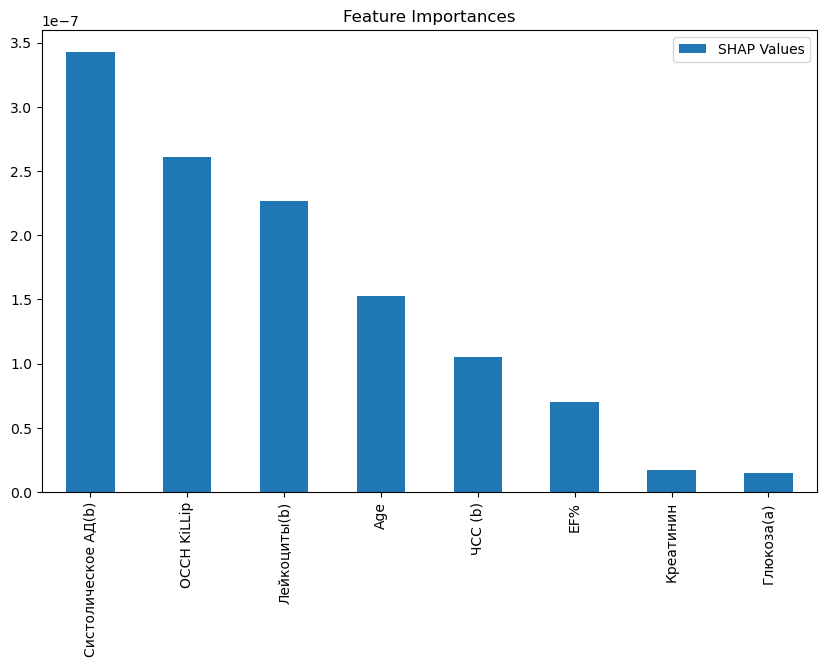

In [ ]:
# Plot the feature importances
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.show()